<h1 style="color:#1A6BD7">Sundance National Bank Marketing Campaign</h1>

## Background and Context ##

Sundance National Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

The objective of this effort is build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

## Objective ##

To predict whether a liability customer will buy a personal loan or not.
* Which variables are most significant ?
* Which segment of customers should be targeted more ?
 
## Data Dictionary ##

* ID: Customer ID
* Age: Customer’s age in completed years
* Experience: #years of professional experience
* Income: Annual income of the customer (in thousand dollars)
* ZIP Code: Home Address ZIP code.
* Family: the Family size of the customer
* CCAvg: Average spending on credit cards per month (in thousand dollars)
* Education: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* Mortgage: Value of house mortgage if any. (in thousand dollars)
* Personal_Loan: Did this customer accept the personal loan offered in the last campaign?
* Securities_Account: Does the customer have securities account with the bank?
* CD_Account: Does the customer have a certificate of deposit (CD) account with the bank?
* Online: Do customers use internet banking facilities?
* CreditCard: Does the customer use a credit card issued by any other Bank (excluding All life Bank)?

## Import Libraries ##

In [1]:
#Uncomment below to download packages

import sys
!{sys.executable} -m pip install --upgrade uszipcode ## Install the uszipcode pip package in the current Jupyter kernel
!{sys.executable} -m pip install --upgrade mlxtend ## Install mlxtend for plotting decision regions.

Requirement already up-to-date: uszipcode in /Users/marcoyukon/opt/anaconda3/lib/python3.8/site-packages (0.2.6)
     |████████████████████████████████| 1.3 MB 400 kB/s eta 0:00:01


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pylab

sns.set(style="darkgrid")  # set stype for seaborn charts
palette = sns.color_palette("Paired", 8) # vs "Paired"

# import statistics libraries
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm
import statistics

# import skylean module for decision tree.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import scipy.stats as stats
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV

## Table of Contents ##

* EDA
    - Univariate Analysis
    - Bivariate Analysis    
* Data Pre-processing
* Model Building - Logistic Regression
* Model Building - Logistic Regression - Performance Evaluation and Improvement
* Model Building - Decision Tree
* Model Building - Decision Tree - Performance evaluation and Improvement
* EDA on the incorrectly predicted data
* Actionable Insights & Recommendations


## User Defined Functions ##

In [3]:
# Section Global functions def
def show_missing_data(df):
    total_nulls = (
        df.isnull().sum().sort_values(ascending=False)
    )  # total number of null values
    total_count = df.count()
    percent = (total_nulls / total_count).sort_values(
        ascending=False
    )  # percentage of values that are null
    missing_data = pd.concat(
        [total_nulls, total_count, percent],
        axis=1,
        keys=["Total Nulls", "Total Rows", "% Null"],
    )  # putting the above two together
    return missing_data  # return the dataframe

###############################################################
# Global variables and constant literals used in this notebook
###############################################################
def constant(f):
    def fset(self, value):
        raise TypeError

    def fget(self):
        return f()

    return property(fget, fset)

class _Constant(object):
    @constant
    def significance_level():
        return 0.05

    # def add additional consts here
const = _Constant()

###############################################################
# Global user defined functions
###############################################################

# Function to enhance plots with percentage
def bar_plot_with_perc(feature,hue):
    
    fig_dims = (10, 4)
    fig, ax = plt.subplots(figsize=fig_dims)

    sns.set_theme(style="darkgrid")    
    #ax = sns.countplot(x=feature, data=df, palette="husl")
    plot = sns.countplot(x=feature, palette="husl", hue=hue, ax=ax)
    total = len(feature)  # length of the column
    
    fig.suptitle(
        "Bivariate Analysis for " + feature.name.upper(),
        fontsize=16,
        fontweight="bold",
    )
    
    for p in plot.patches:
        x = p.get_x() + p.get_width() / 2 - 0.05  # width
        y = p.get_y() + p.get_height()  # height
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage for each slice of the category
        plot.annotate(percentage, (x, y), size=12)  # add the percentage label
    plt.show()

# Section Global functions def
def show_missing_data(df):
    total_nulls = (
        df.isnull().sum().sort_values(ascending=False)
    )  # total number of null values
    total_count = df.count()
    percent = (total_nulls / total_count).sort_values(
        ascending=False
    )  # percentage of values that are null
    missing_data = pd.concat(
        [total_nulls, total_count, percent],
        axis=1,
        keys=["Total Nulls", "Total Rows", "% Null"],
    )  # putting the above two together
    return missing_data  # return the dataframe


# Simple Histogram
def histogram_simple(feature, figsize=(10, 4), title=None):

    if title == None:
        title = "Univariate Analysis for " + feature.name.upper()

    plt.figure(figsize=figsize)
    mean = feature.mean()
    median = feature.median()
    ax = sns.distplot(
        feature,
        rug=True,
        rug_kws={"color": "b"},
        kde_kws={"color": "k", "lw": 1, "label": "KDE"},
        hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "b"},
    )
    ax.set_title(title)
    ax.axvline(
        mean, color="green", linestyle="--", linewidth=2
    )  # Add mean to the histogram
    ax.axvline(
        median, color="black", linestyle="-", linewidth=2
    )  # Add median to the histogram

    plt.legend({"Mean": mean, "Median": median})
    plt.show()


# Histogram/Boxplot combo
def histogram_boxplot(feature, figsize=(12, 4), bins=None):
    # Boxplot and histogram combined
    # feature: 1-d feature array
    # figsize: size of fig default (12,8)
    # bins: number of bins (default None / auto)

    # While doing uni-variate analysis of numerical variables we want to study their central tendency
    # and dispersion.This function takes the numerical column as the input and returns the boxplots
    # and histograms for the variable.

    mean = feature.mean()
    median = feature.median()
    mode = feature.mode().tolist()[0]
    quantile25 = feature.quantile(q=0.25)
    quantile75 = feature.quantile(q=0.75)

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        ncols=1,  # number of cols
        # sharex = True, # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots

    f2.suptitle(
        "Univariate Analysis for " + feature.name.upper(),
        fontsize=16,
        fontweight="bold",
    )
    # Render box plot
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, orient="h", color="#01796F"
    )  # boxplot will be created and a star will indicate the mean value of the column
    ax_box2.set(xlabel="")

    # Render dist plot, for histogram
    sns.distplot(
        feature,
        kde=False,
        label="kde",
        color="#0080FF",
        ax=ax_hist2,
        bins=bins,
        rug=True,
    ) if bins else sns.distplot(
        feature,
        kde=True,
        label="kde",
        color="#0080FF",
        ax=ax_hist2,
        rug=True,
    )

    ax_hist2.axvline(
        mean, label="Mean", color="green", linestyle="--", linewidth=2
    )  # Add mean to the histogram
    ax_hist2.axvline(
        median, label="Median", color="black", linestyle="-", linewidth=1
    )  # Add median to the histogram
    ax_hist2.axvline(
        mode, label="Mode", color="purple", linestyle="dotted", linewidth=1
    )  

    # Add quantile 25% to the histogram
    #     ax_hist2.axvline(
    #         quantile25, label="25% Quantile", color="blue", linestyle="--", linewidth=2
    #     )  # Add quantile 75% to the histogram
    #     ax_hist2.axvline(
    #         quantile75, label="75% Quantile", color="blue", linestyle="--", linewidth=2
    #     )  # Add mode to the histogram

    ax_hist2.legend()

    plt.show()

# determine the skewness in the variables
def skewed_features(data):
    # select_dtypes()- returns a subset of the dataframe based on the data types that are 
    # provided in the 'include' parameter.
    numerical_features = data[
        data.select_dtypes(include=np.number).columns.tolist()
    ]  # data[const.vars_numeric_all]
    skewed_features = numerical_features.apply(lambda x: skew(x.dropna())).sort_values(
        ascending=False
    )
    return skewed_features

def bankdata_show_dist_qq(df,title):
    # Check value distributions for Income, Mortgage, CCAvg to apply the 
    # most appropriate central tendency measure.
    #f, (ax1,ax2) = plt.subplots(1, 1, figsize=(14, 4), sharex=False)
    f, (ax1) = plt.subplots(1, 1, figsize=(6, 3), sharex=False)

    # Distribution Plot
    sns.distplot(df['Income'], color="b", ax=ax1)    
    #sns.distplot(df['CCAvg'], color="r", ax=ax2)    

    plt.suptitle(title,fontsize=16,fontweight="bold")

    plt.tight_layout()
    plt_grid = plt.GridSpec(1,1)

    ### QQ Plot

    #plt.subplots(figsize=(14, 4), sharex=False)
    plt.subplots(figsize=(6, 3), sharex=False)

    ax00= plt.subplot(plt_grid[0,0])
    measurements = df["Income"]
    stats.probplot(measurements, dist="norm", plot=pylab)

    #ax01= plt.subplot(plt_grid[0,1])
    #measurements = df["CCAvg"]
    #stats.probplot(measurements, dist="norm", plot=pylab)
    
    plt.tight_layout();

## Function to create confusion matrix
def draw_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    ## Adapted from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    '''
    y_predict: prediction of class
    y_actual : truth  
    '''
    cm=confusion_matrix(y_actual,y_predict, labels=[1, 0])

    df_cm = pd.DataFrame(cm,
                         index = [i for i in ["1","0"]],
                         columns = [i for i in ['1','0']])
    group_names = ['TP','FN','FP','TN']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=labels,fmt='',cmap='Spectral')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
##  Function to calculate recall score
def get_recall_score(model):
    '''
    model : classifier to predict values of X
    '''
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,pred_test))    

class model_scores:    
    def __init__ (self,model_name,y,pred):
        self.model_name = model_name
        self.y = y
        self.pred = pred        
        self.accuracy_score = metrics.accuracy_score(y,pred)
        self.recall_score = metrics.recall_score(y,pred)
        self.precision_score = metrics.precision_score(y,pred)
        self.f1_score = metrics.f1_score(y,pred)
        
    def __repr__(self):
        d = {
              'name':self.model_name,
              'accuracy':self.accuracy_score,
              'recall':self.recall_score,
              'precision':self.precision_score,
              'f1':self.f1_score                
            }
        return str(d)
    @property
    def name(self):
        return self.model_name
    @property
    def accuracy(self):        
        return self.accuracy_score    
    @property
    def recall(self):        
        return self.recall_score
    @property
    def precision(self):
        return self.precision_score
    @property
    def f1(self):
        return self.f1_score
    @property
    def f1(self):
        return self.f1_score     
    @property
    def scores(self):
        d = {
              'name':self.model_name,
              'accuracy':float("{:.4f}".format(self.accuracy_score)) ,
              'recall':float("{:.4f}".format(self.recall_score)),
              'precision':float("{:.4f}".format(self.precision_score)),
              'f1':float("{:.4f}".format(self.f1_score))               
        }
        return dict(d)

all_models_scores= []  ## Initializing global var that stores the scores for all the models  
def add_to_models_scores(train_scores,test_scores):
    all_models_scores.append(train_scores)
    all_models_scores.append(test_scores)
    
def show_to_model_scores(train_scores,test_scores):     
    print('----')
    print('Accuracy on train data:',train_scores['accuracy'])
    print('Accuracy on test data:',test_scores['accuracy'])
    print('----')
    print('Recall on train data:',train_scores['recall'])
    print('Recall on test data:',test_scores['recall'])
    print('----')
    print('Precision on train data:',train_scores['precision'])
    print('Precision on test data:',test_scores['precision'])
    print('----')
    print('f1 score on train data:',train_scores['f1'])
    print('f1 score on test data:',test_scores['f1'])    

#### Reading the dataset provided for model creation:

In [4]:
df = pd.read_csv("Loan_Modelling.csv")
df_copy = df.copy()
df.head(5)

ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49    91107       4    1.6          1         0   
1   2   45          19      34    90089       3    1.5          1         0   
2   3   39          15      11    94720       1    1.0          1         0   
3   4   35           9     100    94112       1    2.7          2         0   
4   5   35           8      45    91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [5]:
df.tail(5)

ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  \
4995  4996   29           3      40    92697       1    1.9          3   
4996  4997   30           4      15    92037       4    0.4          1   
4997  4998   63          39      24    93023       2    0.3          3   
4998  4999   65          40      49    90034       3    0.5          2   
4999  5000   28           4      83    92612       3    0.8          1   

      Mortgage  Personal_Loan  Securities_Account  CD_Account  Online  \
4995         0              0                   0           0       1   
4996        85              0                   0           0       1   
4997         0              0                   0           0       0   
4998         0              0                   0           0       1   
4999         0              0                   0           0       1   

      CreditCard  
4995           0  
4996           0  
4997           0  
4998           0  
4999           1

#### Checking the shape of the data:

In [6]:
df.shape

(5000, 14)

#### Observations: ####
* The data provided has 5,000 rows and 13 columns

#### Personal loan is the independent variable to predict. Checking the percentage of customers with a loan.

In [7]:
df["Personal_Loan"].value_counts()

0    4520
1     480
Name: Personal_Loan, dtype: int64

#### Observations:
* 480 out of 4520 customers with a personal loan ( ~ 9.6% ).
* At first glance, it appears there is room for a lot of opportunity to sell personal loans.
* Goal is to expand loan sales for customers who have a higher probability of pruchasing the loan.
* A good predictive model can provide support to potential prospective customers that may qualify to a personal loan.

#### Descriptive statistics. Include statistics that summarize the central tendency, dispersion and shape of a dataset’s.

In [8]:
df.drop(["ID"], axis=1).describe().T

count          mean          std      min      25%  \
Age                 5000.0     45.338400    11.463166     23.0     35.0   
Experience          5000.0     20.104600    11.467954     -3.0     10.0   
Income              5000.0     73.774200    46.033729      8.0     39.0   
ZIPCode             5000.0  93169.257000  1759.455086  90005.0  91911.0   
Family              5000.0      2.396400     1.147663      1.0      1.0   
CCAvg               5000.0      1.937938     1.747659      0.0      0.7   
Education           5000.0      1.881000     0.839869      1.0      1.0   
Mortgage            5000.0     56.498800   101.713802      0.0      0.0   
Personal_Loan       5000.0      0.096000     0.294621      0.0      0.0   
Securities_Account  5000.0      0.104400     0.305809      0.0      0.0   
CD_Account          5000.0      0.060400     0.238250      0.0      0.0   
Online              5000.0      0.596800     0.490589      0.0      0.0   
CreditCard          5000.0      0.294000     0.455637      0.0      0.0   

                        50%      75%      max  
Age                    45.0     55.0     67.0  
Experience             20.0     30.0     43.0  
Income                 64.0     98.0    224.0  
ZIPCode             93437.0  94608.0  96651.0  
Family                  2.0      3.0      4.0  
CCAvg                   1.5      2.5     10.0  
Education               2.0      3.0      3.0  
Mortgage                0.0    101.0    635.0  
Personal_Loan           0.0      0.0      1.0  
Securities_Account      0.0      0.0      1.0  
CD_Account              0.0      0.0      1.0  
Online                  1.0      1.0      1.0  
CreditCard              0.0      1.0      1.0

#### Observations:
* Some data cleanup on Experience will have to be done, some experience showing less than 0.
* ZipCode will need to be converted into a broader regional areas like City and State or County and State depending how the data is distributed.
* We can see that that Mortgage and Income is very skewed.

#### Checking data types:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### Observations:
* Data types are set correctly as numeric for modeling.

####  Check for missing data:

In [10]:
show_missing_data(df)

Total Nulls  Total Rows  % Null
CreditCard                    0        5000     0.0
Online                        0        5000     0.0
CD_Account                    0        5000     0.0
Securities_Account            0        5000     0.0
Personal_Loan                 0        5000     0.0
Mortgage                      0        5000     0.0
Education                     0        5000     0.0
CCAvg                         0        5000     0.0
Family                        0        5000     0.0
ZIPCode                       0        5000     0.0
Income                        0        5000     0.0
Experience                    0        5000     0.0
Age                           0        5000     0.0
ID                            0        5000     0.0

#### Observations:
* There are no missing values on the data.

#### Check for duplicate rows in the data.

In [11]:
df.drop(["ID"], axis=1)[df.duplicated()].count() # Excluding ID to show true duplicated rows if they exist.

Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

#### Observations:
* There are no duplicated rows in the data.

In [12]:
#Unique values for each feature
df.apply(lambda x: len(x.unique()))

ID                    5000
Age                     45
Experience              47
Income                 162
ZIPCode                467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal_Loan            2
Securities_Account       2
CD_Account               2
Online                   2
CreditCard               2
dtype: int64

#### Observations:
* There are lots of unique values for ZipCodes to model. WIll convert to a broader segment like city-state or county-state.
* The features with two distinct values are bit values.

#### Looking the skewness for each feature.

In [13]:
skewed_features(df)

CD_Account            3.690606
Personal_Loan         2.742784
Securities_Account    2.587492
Mortgage              2.103371
CCAvg                 1.597964
CreditCard            0.904318
Income                0.841086
Education             0.227025
Family                0.155174
ID                    0.000000
Experience           -0.026317
Age                  -0.029332
ZIPCode              -0.296076
Online               -0.394667
dtype: float64

# Exploratory Data Analysis

### Univariate Analysis

#### Central tendency and dispersion of numerical variables:

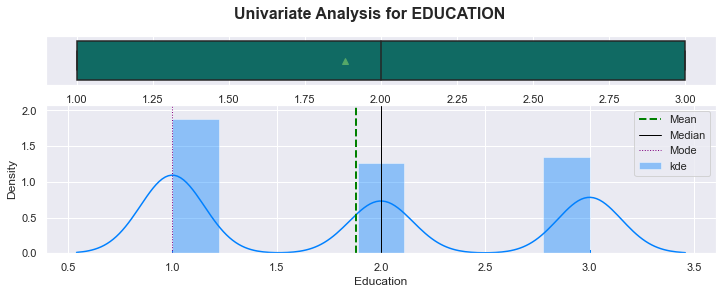

In [14]:
histogram_boxplot(df.Education)

#### Observations:
   * Labels: Education Level=1, Undergrad Level=2, Graduate Level=3, Advanced/Professional=4
   * Median education level is Undergraduate Level

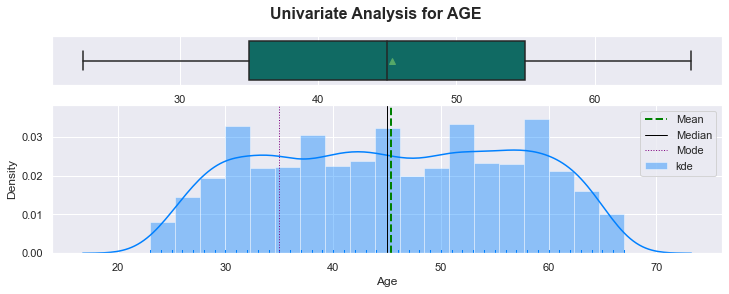

In [15]:
histogram_boxplot(df.Age)

#### Observations:
* Age resembles a normal distribution with very low skewness as it can be abserved on the histogram.
* Mean age of customers is 45 years of age.


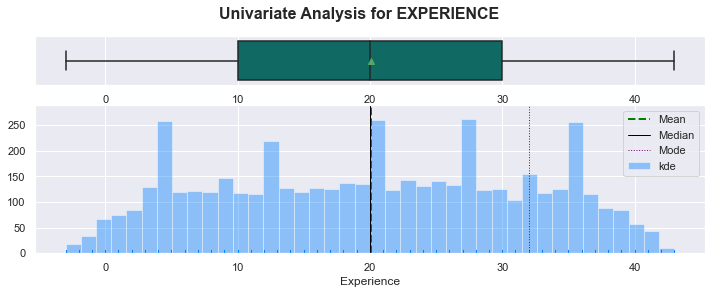

In [16]:
histogram_boxplot(df.Experience,bins=40)

#### Observations:
* Mean and Median of customers experience are 20 years.
* Experience resembles a normal distribution with low skewness.
* Some experiences have negative values and need to be cleanup.

In [17]:
df[df["Experience"] < 0]["Experience"].value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

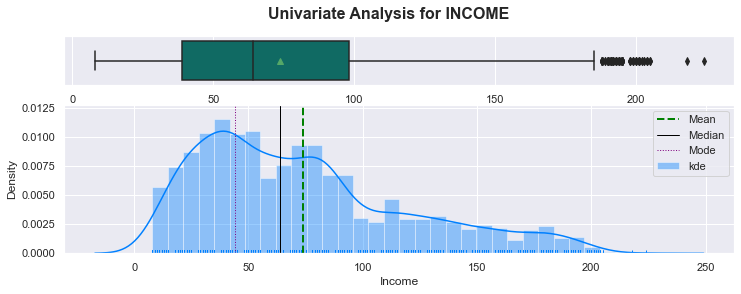

In [18]:
histogram_boxplot(df.Income)

#### Observations:
* Median Income is `~ $ 64K and the mean is ~ $73K`
* Income shows some skewness..
* Note a couple of outliets that is skewing the data that have to be removed later.

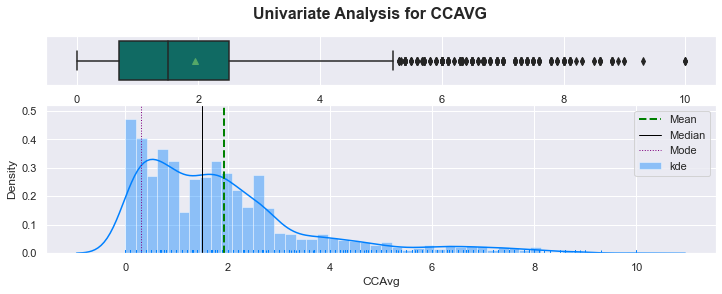

In [19]:
histogram_boxplot(df.CCAvg)

#### Observations:
* Credit Card Avg spending shows some skewness.
* Credit Card Avg median is ~$1.5K and ~1.9K mean.

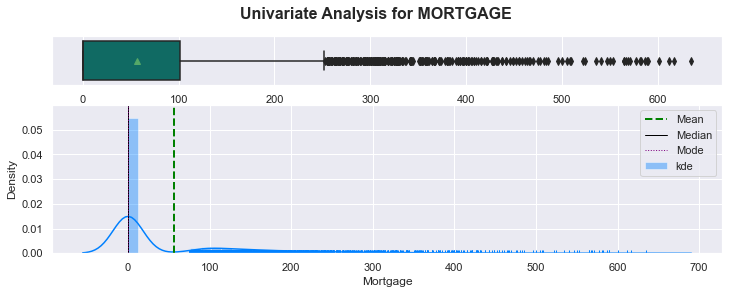

In [20]:
histogram_boxplot(df.Mortgage)

#### Observations:
* Mortgage is highly skewed with most customers having no mortgage.

### Bivariate Analysis

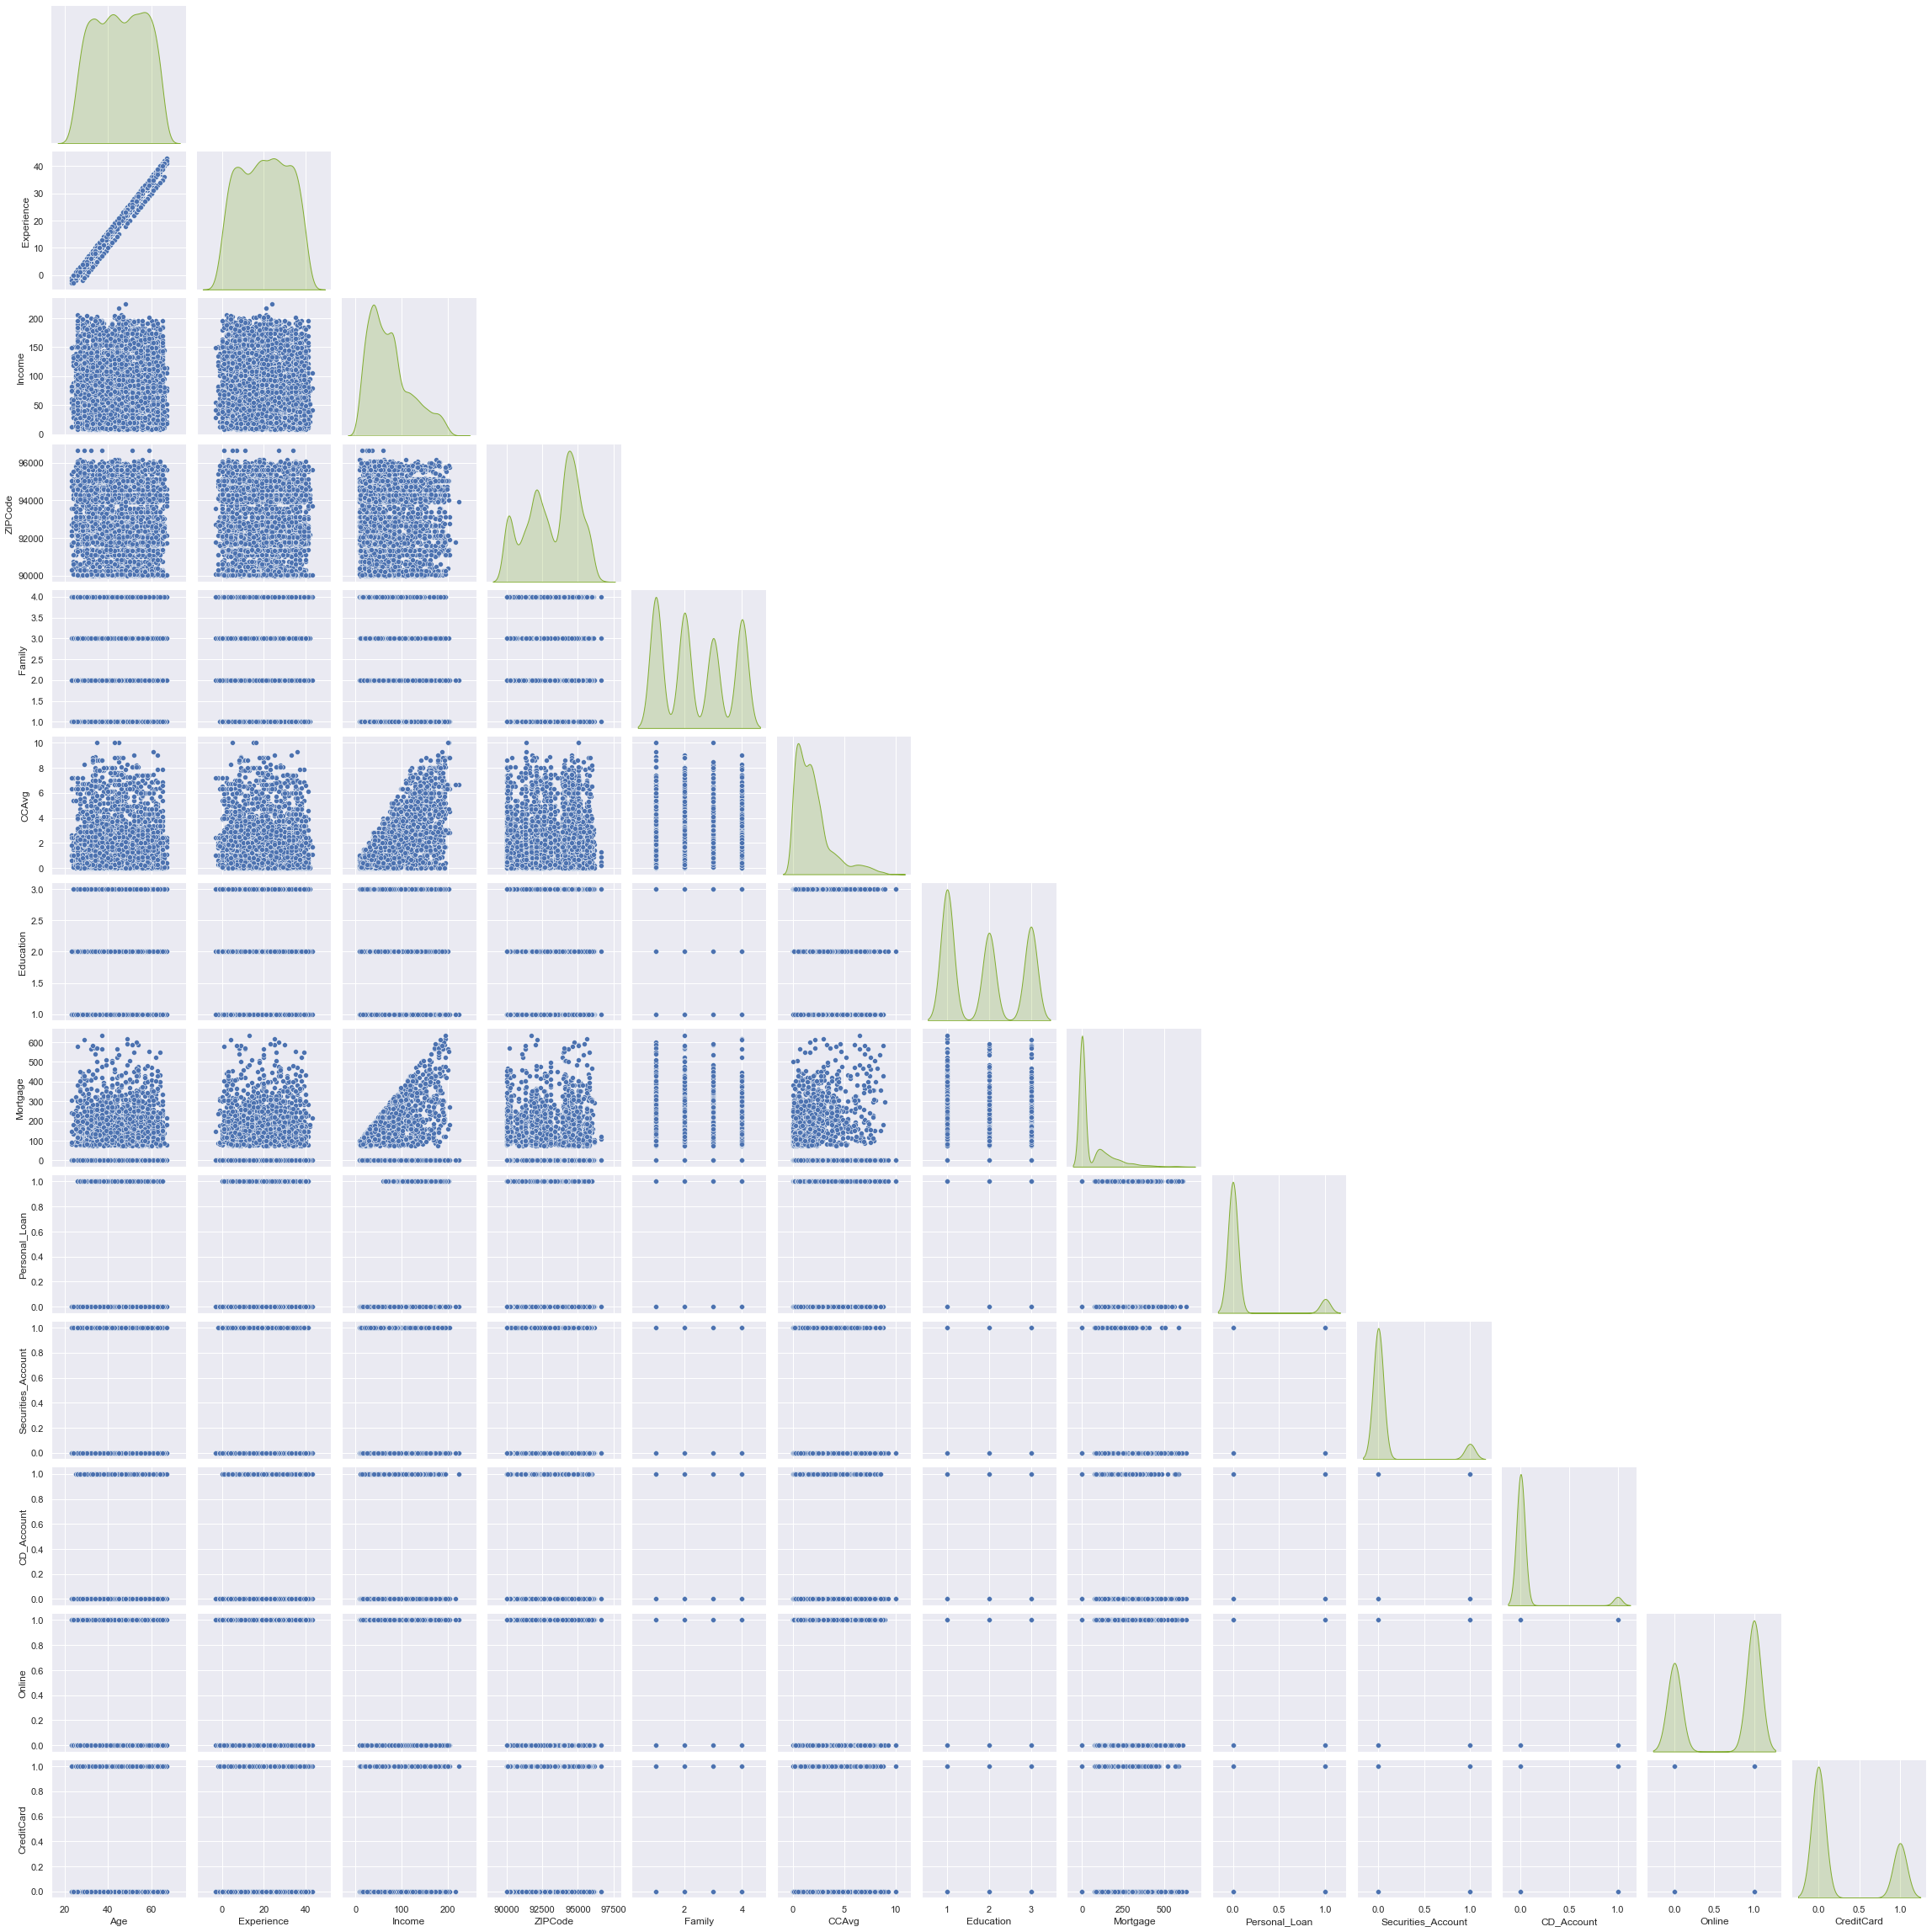

In [21]:
sns.pairplot(data=df.drop(["ID"], axis=1),             
             corner=True,
             diag_kind='kde', # vs. auto
             diag_kws= {'color': '#82ad32'}             
             #kind='reg',
             #plot_kws={'line_kws':{'color':'#aec6cf'}},                          
            )

#### Observations:
* Experience grows with age.
* Mortgage grows with income.

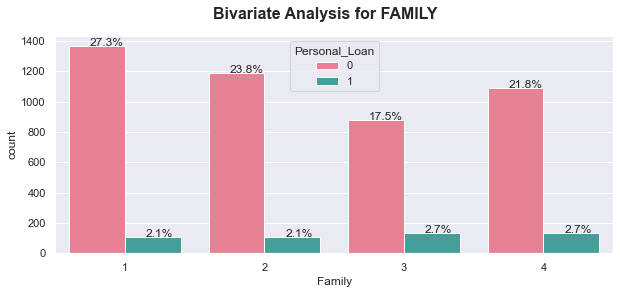

In [22]:
bar_plot_with_perc(feature=df.Family, hue=df.Personal_Loan)

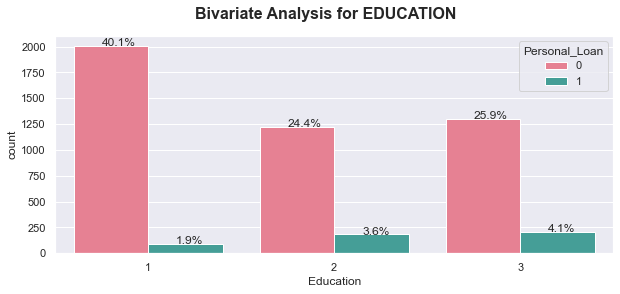

In [23]:
bar_plot_with_perc(df.Education, hue=df.Personal_Loan)

#### Observations:
* 42 % of customers have an undergraduate degree.
* 28 % of customers have an graduate degree.
* 30 % of customers have an advanced or professional degree.

* 4.1 % of customers with a personal loan have advanced or professional degrees, followed by 3.6% of the customers with a loan and a graduate degree.
* 1.9 % of customers with a personal loan have an undergraduate degree.


#### Observations:
* As observed before only 9.6% of the customers have a personal loan

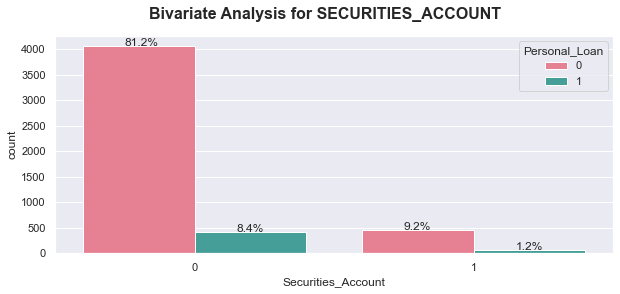

In [24]:
bar_plot_with_perc(df.Securities_Account, hue=df.Personal_Loan)

#### Observations:
* Only 1.2% of the customers with a security account have a personal loan, whereas 8.4% of the customers without a security account have a personal loan.

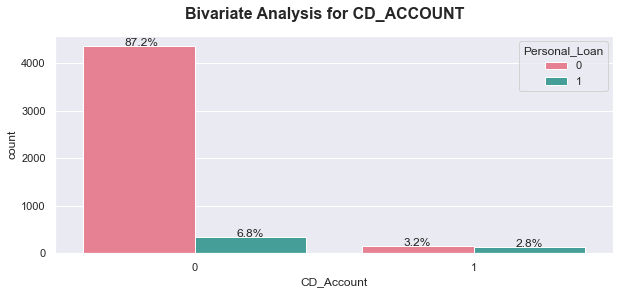

In [25]:
bar_plot_with_perc(df.CD_Account, hue=df.Personal_Loan)

#### Observations:
* Only 2.8% of the customers with a CD Account have a personal loan, whereas 6.8% of the customers without a CD Account have a personal loan.

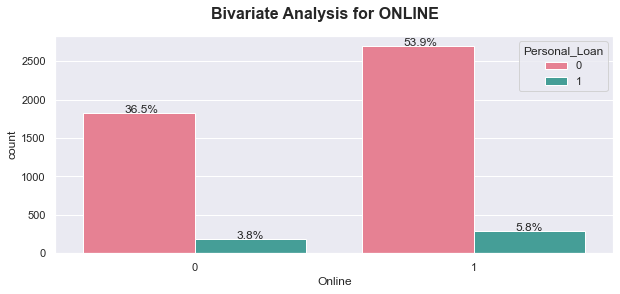

In [26]:
bar_plot_with_perc(df.Online, hue=df.Personal_Loan)

#### Observations:
* 5.8% of the customers using online banking have a personal loan, whereas only 3.8 % of the customers who don't utilize online banking have a personal loan.

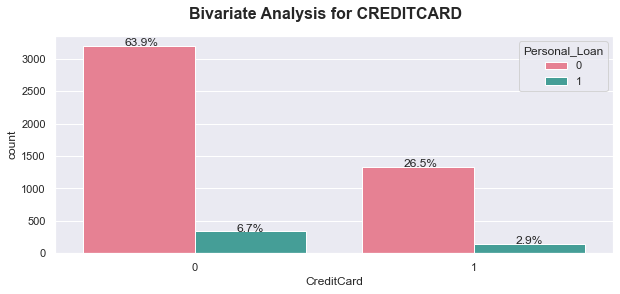

In [27]:
bar_plot_with_perc(df.CreditCard, hue=df.Personal_Loan)

#### Observations:
* Only 2.8% of the customers with credit card from another institution have a personal loan, whereas 6.7% of the customers who don't have a credit card from another institution have a personal loan.

#### Correlations amongst numerical variables. 

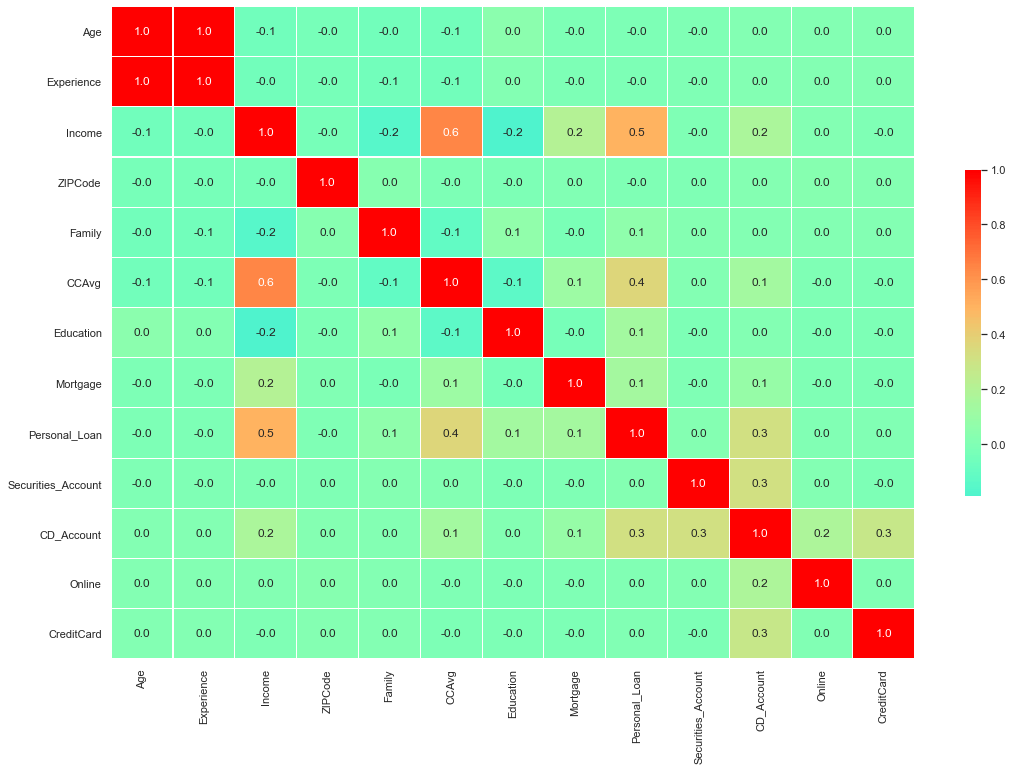

In [28]:
corr = df.drop(["ID"], axis=1).corr()

# plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(
    data=corr,
    annot=True,
    cmap="rainbow",
    fmt=".1f",
    # fmt="d",
    center=0,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=0.1,
    cbar_kws={"shrink": 0.5},    
)
#plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

#### Observations:
* Age and Experience are highly correlated.
* Income and average CC spending are positively correlated.
* There is a positive correlation between Income and personal loan.
* Income and experience shows no correlation.

## Data Pre-Processing

#### Treating column Experience. It contains negative values.

In [29]:
median_experience = df[df["Experience"] > 0]["Experience"].quantile(q=0.5)
print ('There are',df[df["Experience"] < 0]["Experience"].count(),
       'rows of data with customer with experience < 0 years. Opting to replace these with the median instead of dropping them.')

df.loc[df.Experience < 0 , "Experience"] = median_experience;

There are 52 rows of data with customer with experience < 0 years. Opting to replace these with the median instead of dropping them.


In [30]:
df["Experience"].min()

0.0

##### Experience feature treatment has been taken care of.

#### Treating CCAvg and Income Outliers

In [31]:
df.sort_values(by=["Income"],ascending=0)["Income"].head(15)

3896    224
4993    218
526     205
2988    205
4225    204
677     204
2278    204
3804    203
2101    203
787     202
3608    202
1901    201
1711    201
2337    201
4895    201
Name: Income, dtype: int64

#### Categorizing Education

In [32]:
df["Education_Level"]="";
df.loc[df.Education == 1 , "Education_Level"] = "Undergrad";
df.loc[df.Education == 2 , "Education_Level"] = "Graduate";
df.loc[df.Education == 3 , "Education_Level"] = "Advanced_Professional";
df["Education_Level"] = df["Education_Level"].astype("category")

In [33]:
df["Education_Level"].value_counts()

Undergrad                2096
Advanced_Professional    1501
Graduate                 1403
Name: Education_Level, dtype: int64

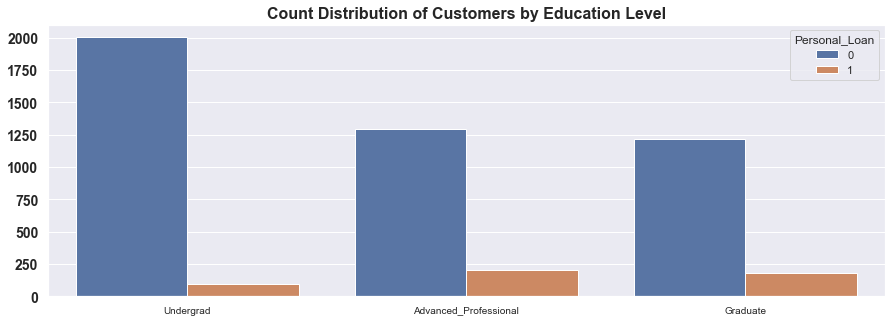

In [34]:
## Plotting customers by education level.
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["Education_Level"],
    order=pd.value_counts(df["Education_Level"]).index,
    hue=df["Personal_Loan"]
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers by Education Level',fontsize=16,fontweight="bold")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=0,fontsize=10,fontweight="normal")
#plt1.set(xticklabels=[])
plt.show()

#### Observations:
* Undergrads have proportionally less personal loans than customers with higher education.
* Most of the customers are undergrads.

#### Binning column experience into experience level categories.

In [35]:
# Entry-Level: 0-2 years, Mid-Level: 3-10, Senior-Level: 11-25, Expert-Level: >15
df['Experience_Level'] = pd.cut(df['Experience'], [0, 2, 10, 15, 9999], labels=['Entry-Level', 'Mid-Level', 'Senior-Level', 'Expert-Level'])

#### Customer Count by Experience Level

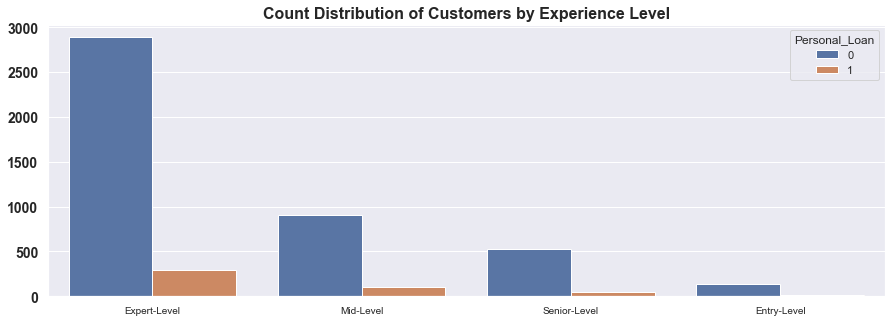

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["Experience_Level"],
    order=pd.value_counts(df["Experience_Level"]).index,
    hue=df["Personal_Loan"]
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers by Experience Level',fontsize=16,fontweight="bold")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=0,fontsize=10,fontweight="normal")
#plt1.set(xticklabels=[])
plt.show()

#### Observations:
* Most of the customers have expert and mid level experiences in their professions.
* A small percentage of customers have entry level experience.

In [37]:
cs_df   = df[df.Personal_Loan==1].groupby(['Experience_Level','Personal_Loan']).agg(['count'])['ID'].sort_values(by=['count'],ascending=0)
cs_df

count
Experience_Level Personal_Loan       
Expert-Level     1                296
Mid-Level        1                109
Senior-Level     1                 51
Entry-Level      1                 17

#### Observations:
* It appears there is a huge business opportunity for customers in the Expert and Mid level experience range.
* A small percentage of customers with entry level experience have a personal loan.

#### There are too many Zip codes to model. Adding to the data frame City-State and County-State from Zip code.

In [38]:
#Using uszipcode lib for public domain geo data using ZipCode as a parameter.
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database

# Creating a new column for city-state
#df["Median_Household_Income"] = ""  ## Adding this public data feature as it may add value to the model.
df["County_State"] = ""
df["City_State"]   = ""

# creating City_State from ZipCode
for i, r in df.iterrows():            
    geo = search.by_zipcode(r.ZIPCode)
    County_State = ("Undetermined" if geo.county==None or geo.state==None else geo.county+'-'+geo.state)
    City_State   = ("Undetermined" if geo.city==None   or geo.state==None else geo.city+'-'+geo.state)
    #Median_Household_Income = (np.nan if geo.median_household_income==None else geo.median_household_income / 1000)  # in Thousands to match the Income data.    
    df.iloc[i, df.columns.get_loc('City_State')]   = City_State
    df.iloc[i, df.columns.get_loc('County_State')] = County_State       
    #df.iloc[i, df.columns.get_loc('Median_Household_Income')] = Median_Household_Income

In [39]:
# changing th datatype from object to category to same some bits of space in memory.
df["County_State"] = df["County_State"].astype("category")    
df["City_State"] = df["City_State"].astype("category")

##### Taking a peek at the new columns added:

In [40]:
df.sample(n=5)

ID  Age  Experience  Income  ZIPCode  Family  CCAvg  Education  \
4247  4248   65        39.0      10    90210       1    0.8          2   
3133  3134   30         5.0      73    93711       3    2.6          3   
984    985   50        25.0      15    92173       1    0.4          3   
868    869   40        15.0     161    94596       2    3.3          1   
2398  2399   53        29.0      90    95053       2    0.3          1   

      Mortgage  Personal_Loan  Securities_Account  CD_Account  Online  \
4247         0              0                   0           0       1   
3133         0              0                   0           0       1   
984          0              0                   0           0       0   
868          0              0                   1           0       0   
2398       217              0                   1           0       0   

      CreditCard        Education_Level Experience_Level  \
4247           0               Graduate     Expert-Level   
3133           0  Advanced_Professional        Mid-Level   
984            0  Advanced_Professional     Expert-Level   
868            1              Undergrad     Senior-Level   
2398           1              Undergrad     Expert-Level   

                County_State        City_State  
4247   Los Angeles County-CA  Beverly Hills-CA  
3133        Fresno County-CA         Fresno-CA  
984      San Diego County-CA     San Ysidro-CA  
868   Contra Costa County-CA   Walnut Creek-CA  
2398   Santa Clara County-CA    Santa Clara-CA

In [41]:
#replacing nan with mean values for median household income
#df['Median_Household_Income'].fillna(value=df['Median_Household_Income'].mean(), inplace=True)

In [42]:
df["City_State"].value_counts()

Los Angeles-CA      375
San Diego-CA        269
San Francisco-CA    257
Berkeley-CA         241
Sacramento-CA       148
                   ... 
Tahoe City-CA         1
Sierra Madre-CA       1
Sausalito-CA          1
Ladera Ranch-CA       1
Stinson Beach-CA      1
Name: City_State, Length: 245, dtype: int64

In [43]:
df["County_State"].value_counts()

Los Angeles County-CA        1095
San Diego County-CA           568
Santa Clara County-CA         563
Alameda County-CA             500
Orange County-CA              339
San Francisco County-CA       257
San Mateo County-CA           204
Sacramento County-CA          184
Santa Barbara County-CA       154
Yolo County-CA                130
Monterey County-CA            128
Ventura County-CA             114
San Bernardino County-CA      101
Contra Costa County-CA         85
Santa Cruz County-CA           68
Riverside County-CA            56
Kern County-CA                 54
Marin County-CA                54
Undetermined                   34
San Luis Obispo County-CA      33
Solano County-CA               33
Humboldt County-CA             32
Sonoma County-CA               28
Fresno County-CA               26
Placer County-CA               24
Butte County-CA                19
Shasta County-CA               18
El Dorado County-CA            17
Stanislaus County-CA           15
San Benito Cou

#### Doing some EDA on City and County.

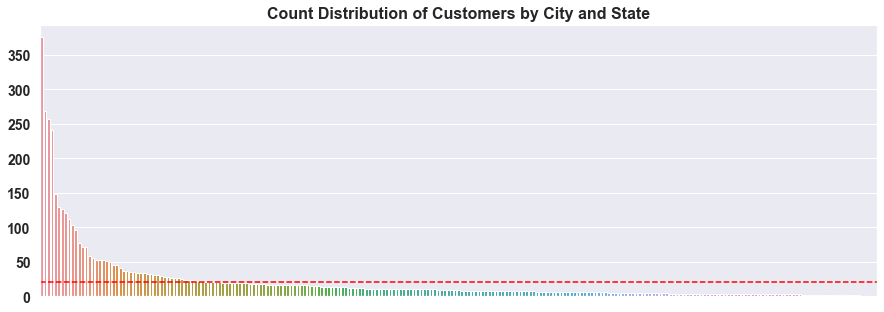

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["City_State"],
    order=pd.value_counts(df["City_State"]).index,
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers by City and State',fontsize=16,fontweight="bold")
plt.axhline(pd.value_counts(df["City_State"]).mean(),color="red",linestyle="--",label="mean")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=60,fontsize=14,fontweight="normal")
plt1.set(xticklabels=[])
plt.show()

#### Top 5 cities with customers

In [45]:
cs_mean = pd.value_counts(df["City_State"]).mean()
cs_df   = df.groupby(['City_State']).agg(['count'])['ID'].sort_values(by=['count'],ascending=0)
top_cities = cs_df[cs_df["count"] > cs_mean]
top_cities.head(5)

count
City_State             
Los Angeles-CA      375
San Diego-CA        269
San Francisco-CA    257
Berkeley-CA         241
Sacramento-CA       148

#### Customer count by county

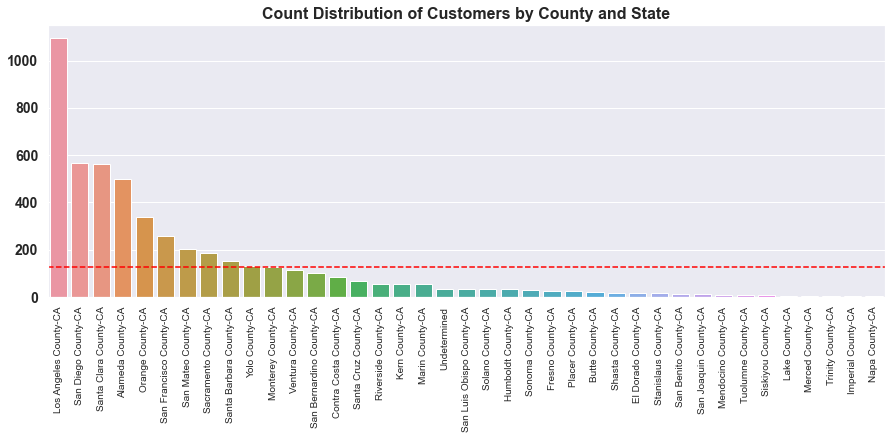

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["County_State"],
    order=pd.value_counts(df["County_State"]).index
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers by County and State',fontsize=16,fontweight="bold")
plt.axhline(pd.value_counts(df["County_State"]).mean(),color="red",linestyle="--",label="mean")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=90,fontsize=10,fontweight="normal")
#plt1.set(xticklabels=[])
plt.show()

#### Observations:
* LA, San Diego, Santa Clara, Orange and SF counties are where most of the customers are in the state of CA.

#### Top 5 counties with customers.

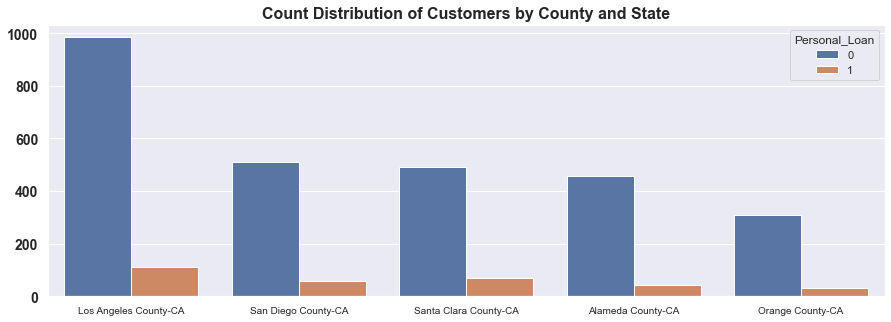

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df["County_State"],
    order=pd.value_counts(df["County_State"]).head(5).index,
    hue=df["Personal_Loan"]
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers by County and State',fontsize=16,fontweight="bold")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=0,fontsize=10,fontweight="normal")
plt.show()

#### Observation:
* There is a lot of room for growth in personal loans in the top counties listed.

#### Top 5 counties with customers who have personal loan.

In [48]:
df[(df.Personal_Loan==1)].groupby(["County_State"])["ID"].count().sort_values(ascending=False).to_frame().head(5)

ID
County_State              
Los Angeles County-CA  111
Santa Clara County-CA   71
San Diego County-CA     59
Alameda County-CA       44
Orange County-CA        30

#### Top 5 counties with customers who DON'T have personal loan.

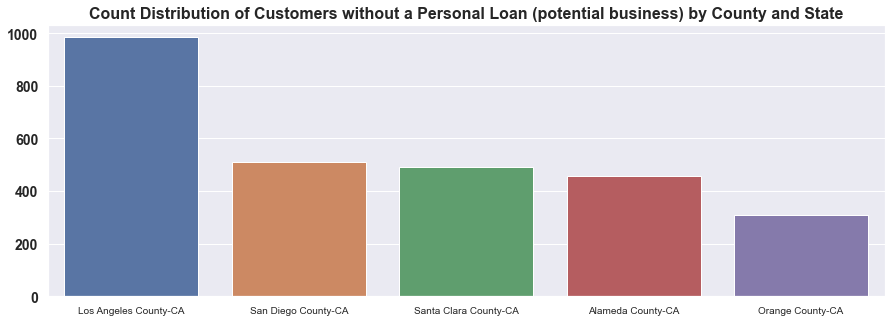

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
plt1 = sns.countplot(
    df[(df.Personal_Loan==0)]["County_State"],
    order=pd.value_counts(df[(df.Personal_Loan==0)]["County_State"]).head(5).index    
)
plt1.set(xlabel=None, ylabel=None)
plt.title('Count Distribution of Customers without a Personal Loan (potential business) by County and State',fontsize=16,fontweight="bold")
plt.yticks(fontsize=14,fontweight="bold")
plt.xticks(rotation=0,fontsize=10,fontweight="normal")
plt.show()

#### Final Observations on County and Personal Loan:
* LA, San Diego, Santa Clara, Orange and Alameda counties are where most of the customers that do not have a personal load are located.
* San Diego county is the second in customers w/o a personal loan, whereas Santa Clara county is second in customers with a personal loan.

## Prepping data data for modeling. Dropping columns not needed and create dummy variables.

In [50]:
# Dropping Id, Experience, City-State and ZIPCode and creating a new dataframe to be used for the predictive decision tree modeling.
dfp = df.drop(["ID","City_State","ZIPCode","Experience","Education"], axis=1)
dfp.head(1)

Age  Income  Family  CCAvg  Mortgage  Personal_Loan  Securities_Account  \
0   25      49       4    1.6         0              0                   1   

   CD_Account  Online  CreditCard Education_Level Experience_Level  \
0           0       0           0       Undergrad      Entry-Level   

            County_State  
0  Los Angeles County-CA

In [51]:
dfp = pd.get_dummies(dfp, columns=['Experience_Level','County_State','Education_Level'],drop_first=True)
dfp.head(1)

Age  Income  Family  CCAvg  Mortgage  Personal_Loan  Securities_Account  \
0   25      49       4    1.6         0              0                   1   

   CD_Account  Online  CreditCard  ...  County_State_Solano County-CA  \
0           0       0           0  ...                              0   

   County_State_Sonoma County-CA  County_State_Stanislaus County-CA  \
0                              0                                  0   

   County_State_Trinity County-CA  County_State_Tuolumne County-CA  \
0                               0                                0   

   County_State_Undetermined  County_State_Ventura County-CA  \
0                          0                               0   

   County_State_Yolo County-CA  Education_Level_Graduate  \
0                            0                         0   

   Education_Level_Undergrad  
0                          1  

[1 rows x 53 columns]

In [52]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     5000 non-null   int64  
 1   Income                                  5000 non-null   int64  
 2   Family                                  5000 non-null   int64  
 3   CCAvg                                   5000 non-null   float64
 4   Mortgage                                5000 non-null   int64  
 5   Personal_Loan                           5000 non-null   int64  
 6   Securities_Account                      5000 non-null   int64  
 7   CD_Account                              5000 non-null   int64  
 8   Online                                  5000 non-null   int64  
 9   CreditCard                              5000 non-null   int64  
 10  Experience_Level_Mid-Level              5000 non-null   uint

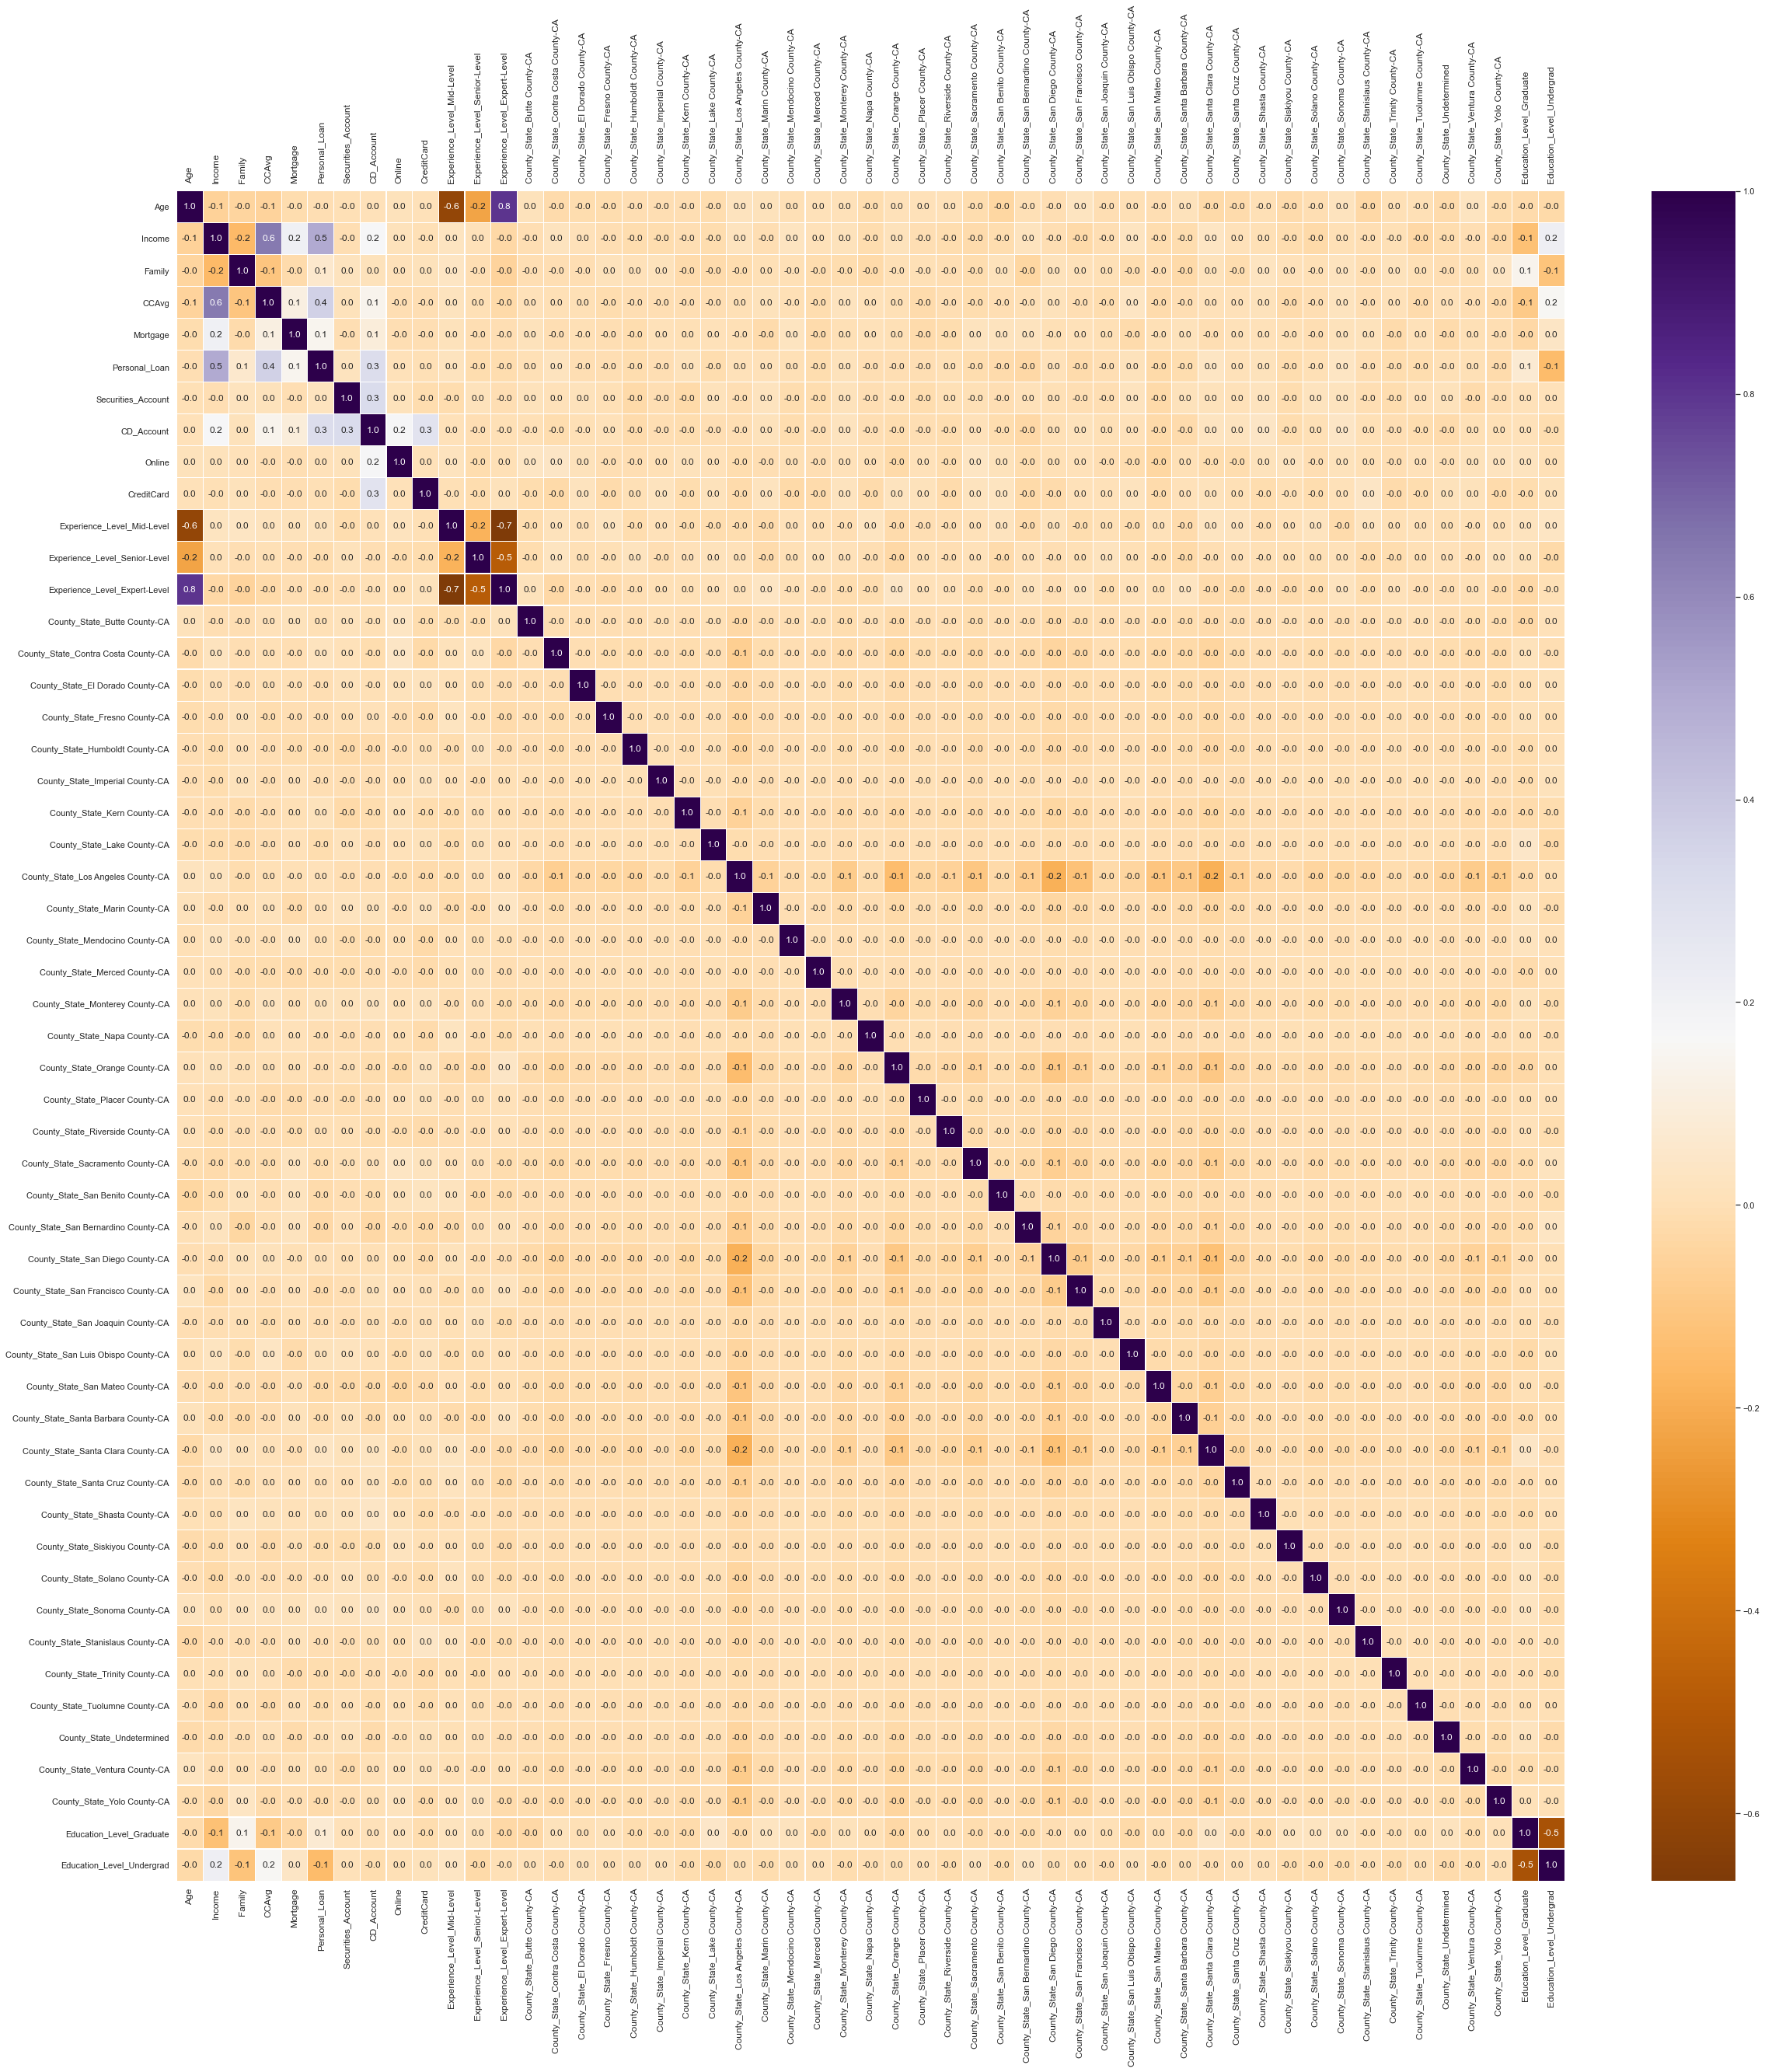

In [53]:
# plot the heatmap pre model building
f, ax = plt.subplots(figsize=[40,40])
sns.heatmap(dfp.corr(), ax=ax,  annot=True, linewidths=0.1, fmt= '.1f',cmap="PuOr")
ax.tick_params(axis='x',
               which='major',
               labelsize=12,
               labelbottom = True,
               bottom=False,
               top = False,
               labelrotation = 90,
               labeltop=True)  #top=False means no ticks
f.show();

## Building Logistic Regression Model - Using StatsModel

**Logistic regression is sentitive to skewness whereas decision trees are not.**

Making a copy of the dataframe so it can be used later (w/o the log transformation), when modeling using decision tree.

In [54]:
dfp_copy = dfp.copy(deep=True)

#### The income predictor is highly skewed. Using log transformation to reduce skewness.

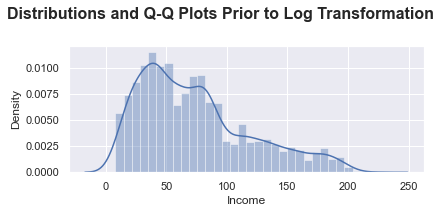

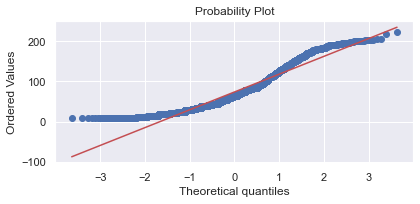

In [55]:
# Show income dist pre log transformation
bankdata_show_dist_qq(dfp,'Distributions and Q-Q Plots Prior to Log Transformation')

In [56]:
# Applying Log transformation
dfp["Income"] = np.log(dfp["Income"])

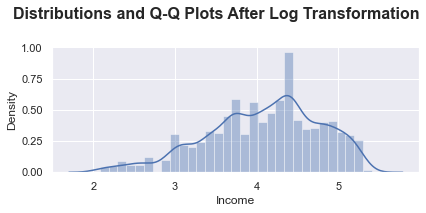

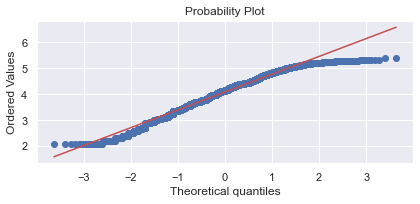

In [57]:
# Show income dist post log transformation
bankdata_show_dist_qq(dfp,'Distributions and Q-Q Plots After Log Transformation')

* Now these look closer to a more normal distribution !
* The Q-Q plot follows the red 45 degree line, which indicates that the data values follow a normal distribution.

#### Defining X and y variables.

In [58]:
X = dfp.drop('Personal_Loan',axis=1)                                                 # Features
y = dfp['Personal_Loan'].astype('int64')                                             # Labels (Target Variable)

#### Partition the data into train and test sets.

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 52 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     5000 non-null   int64  
 1   Income                                  5000 non-null   float64
 2   Family                                  5000 non-null   int64  
 3   CCAvg                                   5000 non-null   float64
 4   Mortgage                                5000 non-null   int64  
 5   Securities_Account                      5000 non-null   int64  
 6   CD_Account                              5000 non-null   int64  
 7   Online                                  5000 non-null   int64  
 8   CreditCard                              5000 non-null   int64  
 9   Experience_Level_Mid-Level              5000 non-null   uint8  
 10  Experience_Level_Senior-Level           5000 non-null   uint

In [60]:
y.to_frame().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Personal_Loan  5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [61]:
# Since will be using X and y in different models, will initiate them at the beginning of each model development.
X_train = None;X_test = None;y_train = None;y_test = None;

In [62]:
# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 42)

In [63]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(dfp.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(dfp.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [64]:
print("Original Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(dfp.loc[dfp['Personal_Loan'] == 1]), (len(dfp.loc[dfp['Personal_Loan'] == 1])/len(dfp.index)) * 100))
print("Original Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(dfp.loc[dfp['Personal_Loan'] == 0]), (len(dfp.loc[dfp['Personal_Loan'] == 0])/len(dfp.index)) * 100))
print("")
print("Training Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Personal Loan True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Personal Loan False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Personal Loan True Values    : 480 (9.60%)
Original Personal Loan False Values   : 4520 (90.40%)

Training Personal Loan True Values    : 323 (9.23%)
Training Personal Loan False Values   : 3177 (90.77%)

Test Personal Loan True Values        : 157 (10.47%)
Test Personal Loan False Values       : 1343 (89.53%)



In [65]:
X_train.shape

(3500, 52)

In [66]:
X_train.head(2)

Age    Income  Family  CCAvg  Mortgage  Securities_Account  CD_Account  \
1840   55  3.135494       4    0.4        88                   0           0   
2115   57  3.401197       3    1.4         0                   0           0   

      Online  CreditCard  Experience_Level_Mid-Level  ...  \
1840       0           0                           0  ...   
2115       0           0                           0  ...   

      County_State_Solano County-CA  County_State_Sonoma County-CA  \
1840                              0                              0   
2115                              0                              0   

      County_State_Stanislaus County-CA  County_State_Trinity County-CA  \
1840                                  0                               0   
2115                                  0                               0   

      County_State_Tuolumne County-CA  County_State_Undetermined  \
1840                                0                          0   
2115                                0                          0   

      County_State_Ventura County-CA  County_State_Yolo County-CA  \
1840                               0                            0   
2115                               0                            0   

      Education_Level_Graduate  Education_Level_Undergrad  
1840                         0                          0  
2115                         0                          1  

[2 rows x 52 columns]

In [67]:
X_test.shape

(1500, 52)

In [68]:
X_test.head(2)

Age    Income  Family  CCAvg  Mortgage  Securities_Account  CD_Account  \
1501   30  3.555348       2    0.3         0                   1           0   
2586   47  5.003946       4    6.1         0                   0           0   

      Online  CreditCard  Experience_Level_Mid-Level  ...  \
1501       0           1                           1  ...   
2586       0           1                           0  ...   

      County_State_Solano County-CA  County_State_Sonoma County-CA  \
1501                              0                              0   
2586                              0                              0   

      County_State_Stanislaus County-CA  County_State_Trinity County-CA  \
1501                                  0                               0   
2586                                  0                               0   

      County_State_Tuolumne County-CA  County_State_Undetermined  \
1501                                0                          0   
2586                                0                          0   

      County_State_Ventura County-CA  County_State_Yolo County-CA  \
1501                               0                            0   
2586                               0                            0   

      Education_Level_Graduate  Education_Level_Undergrad  
1501                         1                          0  
2586                         0                          1  

[2 rows x 52 columns]

## lg1 Logit Model

In [69]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

# adding constant to training and test set
X_train1 = sm.add_constant(X_train)
X_test1 = sm.add_constant(X_test)

In [70]:
logit1 = sm.Logit(y_train,X_train1)
lg1 = logit1.fit()

# Logit results summary
print(lg1.summary2())

# Predict Train
y_predTrain = lg1.predict(X_train1) 
pred_train = list(map(round, y_predTrain))
# Predict Test
y_predTest = lg1.predict(X_test1) 
pred_test = list(map(round, y_predTest))

# Calculate and save scores for later comparison with other models.
train_score1 =model_scores('lg1 - Logistic Regression - Initial Model - Train',y_train,pred_train).scores
test_score1  =model_scores('lg1 - Logistic Regression - Initial Model - Test',y_test,pred_test).scores

all_model_scores = []
add_to_models_scores(train_scores=train_score1,test_scores=test_score1)

# Show Scores
show_to_model_scores(train_scores=train_score1,test_scores=test_score1)

         Current function value: 0.105002
         Iterations: 35
                                                  Results: Logit
Model:                               Logit                            Pseudo R-squared:                 0.659      
Dependent Variable:                  Personal_Loan                    AIC:                              841.0174   
Date:                                2021-06-18 21:50                 BIC:                              1167.5249  
No. Observations:                    3500                             Log-Likelihood:                   -367.51    
Df Model:                            52                               LL-Null:                          -1077.3    
Df Residuals:                        3447                             LLR p-value:                      7.1258e-263
Converged:                           0.0000                           Scale:                            1.0000     
No. Iterations:                      35.0000             

### Check and treat multicollinearity

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_series1 = pd.Series([variance_inflation_factor(X_train1.values,i) for i in range(X_train1.shape[1])],index=X_train1.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                                     105.370604
Age                                         3.250501
Income                                      1.631651
Family                                      1.060609
CCAvg                                       1.565225
Mortgage                                    1.062535
Securities_Account                          1.149554
CD_Account                                  1.333398
Online                                      1.055923
CreditCard                                  1.126151
Experience_Level_Mid-Level                  4.325931
Experience_Level_Senior-Level               3.424894
Experience_Level_Expert-Level               9.069382
County_State_Butte County-CA                1.048752
County_State_Contra Costa County-CA         1.168979
County_State_El Dorado County-CA            1.038567
County_State_Fresno County-CA               1.045417
County_State_Humboldt County-CA             1.066126
County_Stat

* VIF summary shows none of the regressors are correlated (VIF>10).

### Dropping insignificant variables

In [72]:
#Eliminate features not statistically significant highest to lowest (those with p-value greater than 0.05)
X_train2 = X_train1.drop(['Experience_Level_Expert-Level','County_State_El Dorado County-CA','County_State_Lake County-CA','County_State_Mendocino County-CA','County_State_Siskiyou County-CA',
                          'County_State_Imperial County-CA','County_State_San Benito County-CA','County_State_Trinity County-CA','County_State_Tuolumne County-CA','County_State_Napa County-CA',
                          'County_State_Merced County-CA','County_State_Placer County-CA',
                          'Experience_Level_Senior-Level','Experience_Level_Mid-Level','Education_Level_Graduate'], axis =1)

X_test2 = X_test1.drop(['Experience_Level_Expert-Level','County_State_El Dorado County-CA','County_State_Lake County-CA','County_State_Mendocino County-CA','County_State_Siskiyou County-CA',
                        'County_State_Imperial County-CA','County_State_San Benito County-CA','County_State_Trinity County-CA','County_State_Tuolumne County-CA','County_State_Napa County-CA',
                        'County_State_Merced County-CA','County_State_Placer County-CA',
                        'Experience_Level_Senior-Level','Experience_Level_Mid-Level','Education_Level_Graduate',],axis =1)

### lg2  Logit model

In [73]:
logit2 = sm.Logit(y_train, X_train2 )
lg2 = logit2.fit()
print(lg2.summary2())

# Predict Train - Using default threshold
y_predTrain = lg2.predict(X_train2)#>0.5   # Default threshhold is 0.5, uncomment  if needed to check.
pred_train  = list(map(round, y_predTrain))
# Predict Test - Using default threshold
y_predTest  = lg2.predict(X_test2)#>0.5    # Default threshhold is 0.5, uncomment if needed to check.
pred_test   = list(map(round, y_predTest))

# Calculate and save scores for later comparison with other models.
train_score2 = model_scores('lg2 - Logistic Regression - w/o n.s. features - Train',y_train,pred_train).scores
test_score2  = model_scores('lg2 - Logistic Regression - w/o n.s. features - Test',y_test,pred_test).scores
add_to_models_scores(train_scores=train_score2,test_scores=test_score2)

# Show Scores
show_to_model_scores(train_scores=train_score2,test_scores=test_score2)

Optimization terminated successfully.
         Current function value: 0.105356
         Iterations 10
                                      Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.658      
Dependent Variable:         Personal_Loan            AIC:                      813.4922   
Date:                       2021-06-18 21:50         BIC:                      1047.5919  
No. Observations:           3500                     Log-Likelihood:           -368.75    
Df Model:                   37                       LL-Null:                  -1077.3    
Df Residuals:               3462                     LLR p-value:              1.0088e-273
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             10.0000                                                       
------------------------------------------------------------------------------------------
                         

### Observations:

### Choosing lg2 for prediction and inferences:
**We can observe that logit model lg2 resulted in a better fit for the train data.**

**The recall score on the test set is 0.732, compared to 0.745 observed in the lg1 model.**
* Some of the important features or predictors are: 
Income,Family,CCAvg,Securities_Account,CD_Account,Online,CreditCard,Education_Level_Undergrad,County_State_Riverside County-CA.
* Undergrads have less probability of getting a personal loan, when compared with graduates and customers with advanced education / professionals.
* An unit increase in age increases the chances of getting a loan by 1.17%
* Having a CD Account greatly increases the probability of getting a loan.
* Having credit cards with another bank reduces the chance of getting a loan.
* Having a high income greatly increases the change of getting a loan.

### lg2 Model Performance

In [74]:
print('Model Performance Measures - with 0.5 threshold:')
show_to_model_scores(train_scores=train_score2,test_scores=test_score2)

Model Performance Measures - with 0.5 threshold:
----
Accuracy on train data: 0.9649
Accuracy on test data: 0.9633
----
Recall on train data: 0.6997
Recall on test data: 0.7452
----
Precision on train data: 0.8968
Precision on test data: 0.8864
----
f1 score on train data: 0.7861
f1 score on test data: 0.8097


### Generating the ROC curve:

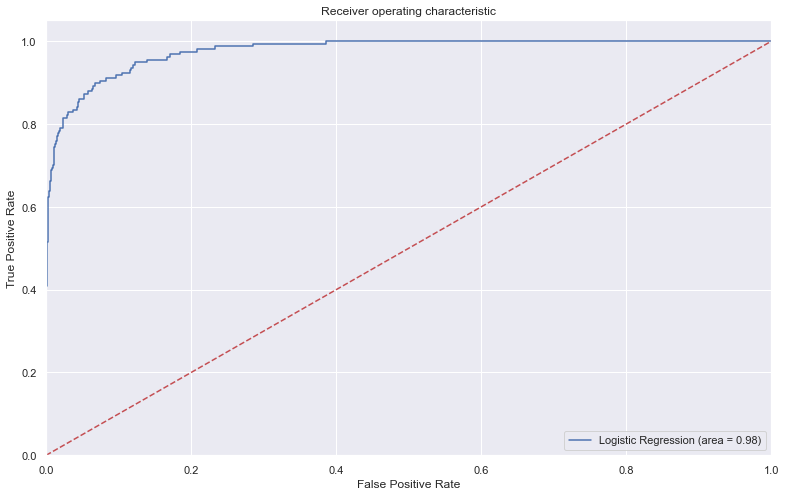

In [75]:
### AUC ROC curve - Using lg2 chosen model ###

### FPR = FP / (FP+TN)
### TPR = TP / (TP+FN) or Recall

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, lg2.predict(X_test2)) 
fpr, tpr, thresholds = roc_curve(y_test, lg2.predict(X_test2))
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [76]:
##ROC datapoints
roc_df = pd.DataFrame(dict(frp=fpr,tpr=tpr,threshold=thresholds))
roc_df["threshold"] = roc_df["threshold"].apply(lambda x: float("{:.5f}".format(x)))
roc_df

frp       tpr  threshold
0    0.000000  0.000000    1.99955
1    0.000000  0.006369    0.99955
2    0.000000  0.407643    0.90860
3    0.000745  0.407643    0.90516
4    0.000745  0.477707    0.84844
..        ...       ...        ...
97   0.285927  0.987261    0.00944
98   0.285927  0.993631    0.00917
99   0.385704  0.993631    0.00274
100  0.385704  1.000000    0.00272
101  1.000000  1.000000    0.00000

[102 rows x 3 columns]

### Area Under the Curve (AUC) Score

* The roc auc score is the area under the curve.
* The roc_auc_score always runs from 0 to 1, and is sorting predictive possibilities.
* 0.5 is the baseline for random guessing.
* You would want to always get above the roc_auc_score above 0.5, with 0.5 denoting a bad classifier and 1 denoting an excellent classifier.

In [77]:
print ('The roc_auc_score is: ',roc_auc_score(y_test, lg2.predict(X_test2)))

The roc_auc_score is:  0.9767276417944426


* The lg2 model shows almost a perfect ROC AUC score.

### Let's try to improve further the recall on lg2 using the AUC-ROC curve

* Find the optimal threshold per AUC-ROC curve.
* The optimal cut off would be where the **True positive rate is high** and **False positive rate is low**.

In [78]:
# Optimal threshold as per AUC-ROC curve.
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lg2.predict(X_test2))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('The optimal threshold:',optimal_threshold)
print('The optimal frp,tpr according to roc:')
roc_df[roc_df.threshold == float("{:.5f}".format(optimal_threshold))]

The optimal threshold: 0.16834376890386607
The optimal frp,tpr according to roc:


frp       tpr  threshold
68  0.067759  0.898089    0.16834

### Trying now lg2 with optimal threshold

In [79]:
y_pred_train_opt1 = (lg2.predict(X_train2)>optimal_threshold).astype(int)
y_pred_test_opt1  = (lg2.predict(X_test2)>optimal_threshold).astype(int)

# Calculate and save scores for later comparison with other models.
train_score_opt1 = model_scores('lg2 - Logistic Regression - ROC-AUC optimal-threshold - Train',y_train,y_pred_train_opt1).scores
test_score_opt1  = model_scores('lg2 - Logistic Regression - ROC-AUC optimal-threshold - Test',y_test,y_pred_test_opt1).scores
add_to_models_scores(train_scores=train_score_opt1,test_scores=test_score_opt1)

In [80]:
print('Model Performance Measures - with ROC-AUC optimal threshold',optimal_threshold)
show_to_model_scores(train_scores=train_score_opt1,test_scores=test_score_opt1)

Model Performance Measures - with ROC-AUC optimal threshold 0.16834376890386607
----
Accuracy on train data: 0.9329
Accuracy on test data: 0.928
----
Recall on train data: 0.8793
Recall on test data: 0.8917
----
Precision on train data: 0.5917
Precision on test data: 0.6061
----
f1 score on train data: 0.7073
f1 score on test data: 0.7216


### Observation on using optimal threshold:
* Reducing the threshold from the default **0.5** to the optimal threshhold of **0.168**, impacted on a great improvement in lg2 recall from **0.7452 to 0.8917** but reduced the precision on the test set from **0.8864 to 0.6061**, which would result in more false positives and unnecessary effort to sell a loan, but at the benefit of further improving sales of personal loans (due to the higher recall score ).

### Precision-Recall curve on lg2

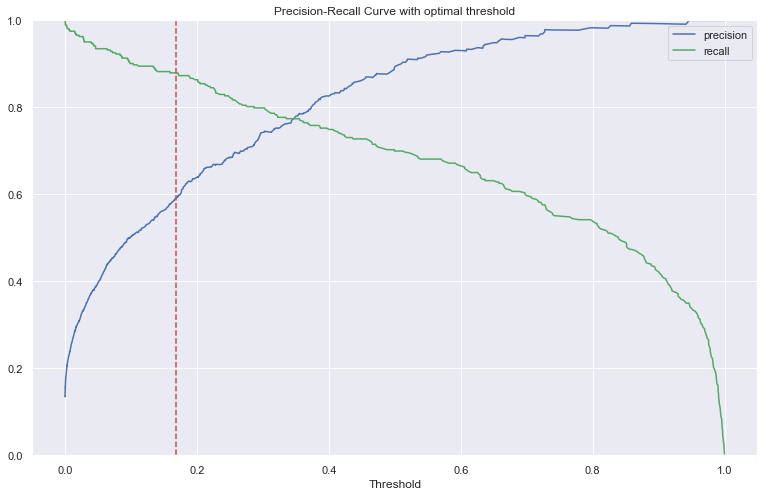

In [81]:
# Precision = TP/(TP+FP)
# Recall (or TPR) = TP/(TP+FN)

from sklearn.metrics import precision_recall_curve
y_pred=lg2.predict(X_train2)
prec, rec, tre = precision_recall_curve(y_train, y_pred)

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds, optimal_threshold):
    plt.figure(figsize=(13,8))
    plt.plot(thresholds, precisions[:-1], 'b-', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper right')
    plt.ylim([0,1])
    plt.axvline(x=optimal_threshold,color='r', linestyle='--')   
    plt.title('Precision-Recall Curve with optimal threshold')
    
plot_prec_recall_vs_tresh(prec, rec, tre,optimal_threshold)
plt.show()

#### The precision-recall interset

In [82]:
tre1 = np.append(tre, 0.999999)
#print(len(rec), len(prec), len(tre1))
print ('recall/precision intersect:',rec[rec==prec])
print('recall/precision intersect threshold:')
prec_rec_tre_df = pd.DataFrame(dict(recall=rec,precision=prec,threshold=tre1))
prec_rec_tre_df[prec_rec_tre_df.recall==prec_rec_tre_df.precision]

recall/precision intersect: [0.77399381]
recall/precision intersect threshold:


recall  precision  threshold
2065  0.773994   0.773994   0.347111

In [83]:
# recall precision where the optimal threshold is met.
prec_rec_tre_df[prec_rec_tre_df.threshold<=optimal_threshold].tail(1)

recall  precision  threshold
1907  0.879257   0.590437   0.167594

### Observation:
* Reducing the threshold beyond 0.168 would increase recall, but would rapidly reduce precision (i.e: higher number of FP). 
* The intersect of recall and precision is ~ 0.167.

### Confusion Matrix

In [84]:
# Adapted from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
from sklearn.metrics import classification_report,confusion_matrix
def plot_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : truth  
    '''
    cm=confusion_matrix( y_actual,y_predict, labels=[1, 0])

    df_cm = pd.DataFrame(cm,
                         index = [i for i in ["1","0"]],
                         columns = [i for i in ['1','0']])
    group_names = ['TP','FN','FP','TN']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=labels,fmt='',cmap='Spectral')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

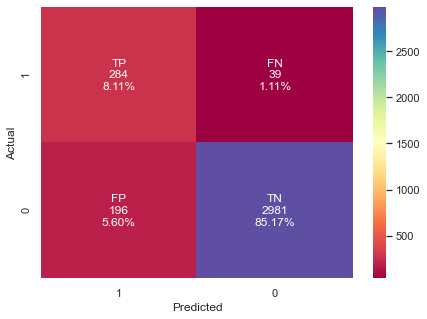

In [85]:
# Make confusion matrix on train set.
draw_confusion_matrix(y_train,y_pred_train_opt1)

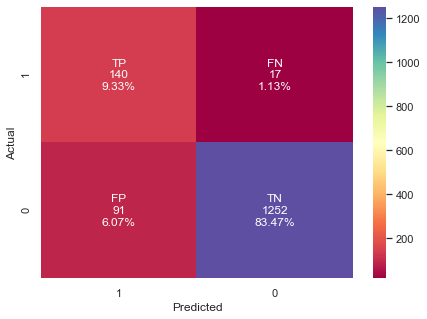

In [86]:
# Make confusion matrix on test set.
draw_confusion_matrix(y_test,y_pred_test_opt1)

In [87]:
print('lg2 - with ROC-AUC optimal threshold',optimal_threshold)
show_to_model_scores(train_scores=train_score_opt1,test_scores=test_score_opt1)

lg2 - with ROC-AUC optimal threshold 0.16834376890386607
----
Accuracy on train data: 0.9329
Accuracy on test data: 0.928
----
Recall on train data: 0.8793
Recall on test data: 0.8917
----
Precision on train data: 0.5917
Precision on test data: 0.6061
----
f1 score on train data: 0.7073
f1 score on test data: 0.7216


### Final conclusion using logistic regression for classification:

* lg2 is the selected logitic model with the optimal threshold. 
* Using the test set, we are able to predict ~89% on the recall test which is great on identifying those customers who will obtain a personal loan.
* Since the priority is to **increase** the sales of personal loans, (i.e: higher recall - lower FN), model lg2 is superior than the previous models.
* The model has ~60% precision on the test set. This means the model is not very good at classifying customers who won't get a personal loan (i.e: relative higher FP), which means a high opportunity cost, due to unnecessary effort invested on those who won't obtain a loan.

## Model Building - Trying now Decision Tree as a classifier.

#### 1) Defining X and y variables.

In [88]:
dfp2 = dfp_copy.copy(deep=True)

In [89]:
X = dfp2.drop('Personal_Loan',axis=1)                                                 # Features
y = dfp2['Personal_Loan'].astype('int64')                                             # Labels (Target Variable)

#### 2) Partition the data into train and test sets.

In [90]:
X_train=None; X_test=None; y_train=None; y_test==None;

In [91]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(3500, 52) (1500, 52)


In [92]:
X_train.head(1)

Age  Income  Family  CCAvg  Mortgage  Securities_Account  CD_Account  \
1334   47      35       2    1.3         0                   0           0   

      Online  CreditCard  Experience_Level_Mid-Level  ...  \
1334       1           0                           0  ...   

      County_State_Solano County-CA  County_State_Sonoma County-CA  \
1334                              0                              0   

      County_State_Stanislaus County-CA  County_State_Trinity County-CA  \
1334                                  0                               0   

      County_State_Tuolumne County-CA  County_State_Undetermined  \
1334                                0                          0   

      County_State_Ventura County-CA  County_State_Yolo County-CA  \
1334                               0                            0   

      Education_Level_Graduate  Education_Level_Undergrad  
1334                         0                          1  

[1 rows x 52 columns]

#### Checking the split of the data into train and test sets.

In [93]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(dfp.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(dfp.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [94]:
print("Original Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(dfp.loc[dfp['Personal_Loan'] == 1]), (len(dfp.loc[dfp['Personal_Loan'] == 1])/len(dfp.index)) * 100))
print("Original Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(dfp.loc[dfp['Personal_Loan'] == 0]), (len(dfp.loc[dfp['Personal_Loan'] == 0])/len(dfp.index)) * 100))
print("")
print("Training Personal Loan True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Personal Loan False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Personal Loan True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Personal Loan False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Personal Loan True Values    : 480 (9.60%)
Original Personal Loan False Values   : 4520 (90.40%)

Training Personal Loan True Values    : 331 (9.46%)
Training Personal Loan False Values   : 3169 (90.54%)

Test Personal Loan True Values        : 149 (9.93%)
Test Personal Loan False Values       : 1351 (90.07%)



## dTree1 - Initial decision tree model

* The model will be using the DecisionTreeClassifier function. Using default 'gini' criteria to split.

In [95]:
dTree1 = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [96]:
#Predict on train and test
y_predict_train1 = dTree1.predict(X_train)
y_predict_test1 = dTree1.predict(X_test)

In [97]:
# Calculate and save scores for later comparison with other models.
train_score_dt1 = model_scores('dTree1 - Decision Tree - Initial Model - Train',y_train,y_predict_train1).scores
test_score_dt1  = model_scores('dTree1 - Decision Tree - Initial Model - Test',y_test,y_predict_test1).scores
add_to_models_scores(train_scores=train_score_dt1,test_scores=test_score_dt1)

In [98]:
print('Decision Tree Model - Initial Scores')
show_to_model_scores(train_scores=train_score_dt1,test_scores=test_score_dt1)

Decision Tree Model - Initial Scores
----
Accuracy on train data: 1.0
Accuracy on test data: 0.976
----
Recall on train data: 1.0
Recall on test data: 0.8658
----
Precision on train data: 1.0
Precision on test data: 0.8897
----
f1 score on train data: 1.0
f1 score on test data: 0.8776


### Observation
* The initlal tree generated is clearly overfitted.

## Confusion Matrix

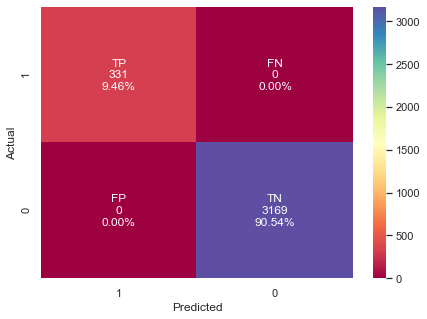

In [99]:
#Confusion matrix on the train set.
y_predict_train1 = dTree1.predict(X_train)
draw_confusion_matrix(y_train,y_predict_train1)

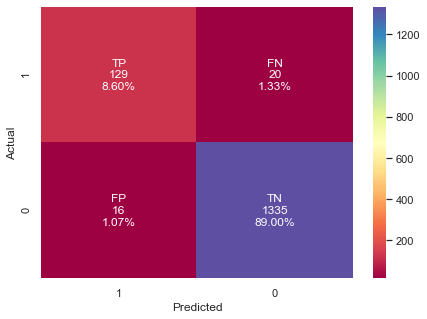

In [100]:
#Confusion matrix on the test set.
y_predict_test1 = dTree1.predict(X_test)
draw_confusion_matrix(y_test,y_predict_test1)

### Visualizing the Decision Tree

In [101]:
#Printing the features
feature_names = list(X.columns)
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Experience_Level_Mid-Level', 'Experience_Level_Senior-Level', 'Experience_Level_Expert-Level', 'County_State_Butte County-CA', 'County_State_Contra Costa County-CA', 'County_State_El Dorado County-CA', 'County_State_Fresno County-CA', 'County_State_Humboldt County-CA', 'County_State_Imperial County-CA', 'County_State_Kern County-CA', 'County_State_Lake County-CA', 'County_State_Los Angeles County-CA', 'County_State_Marin County-CA', 'County_State_Mendocino County-CA', 'County_State_Merced County-CA', 'County_State_Monterey County-CA', 'County_State_Napa County-CA', 'County_State_Orange County-CA', 'County_State_Placer County-CA', 'County_State_Riverside County-CA', 'County_State_Sacramento County-CA', 'County_State_San Benito County-CA', 'County_State_San Bernardino County-CA', 'County_State_San Diego County-CA', 'County_State_San Francisco County-CA', 'County_State_San Joaquin

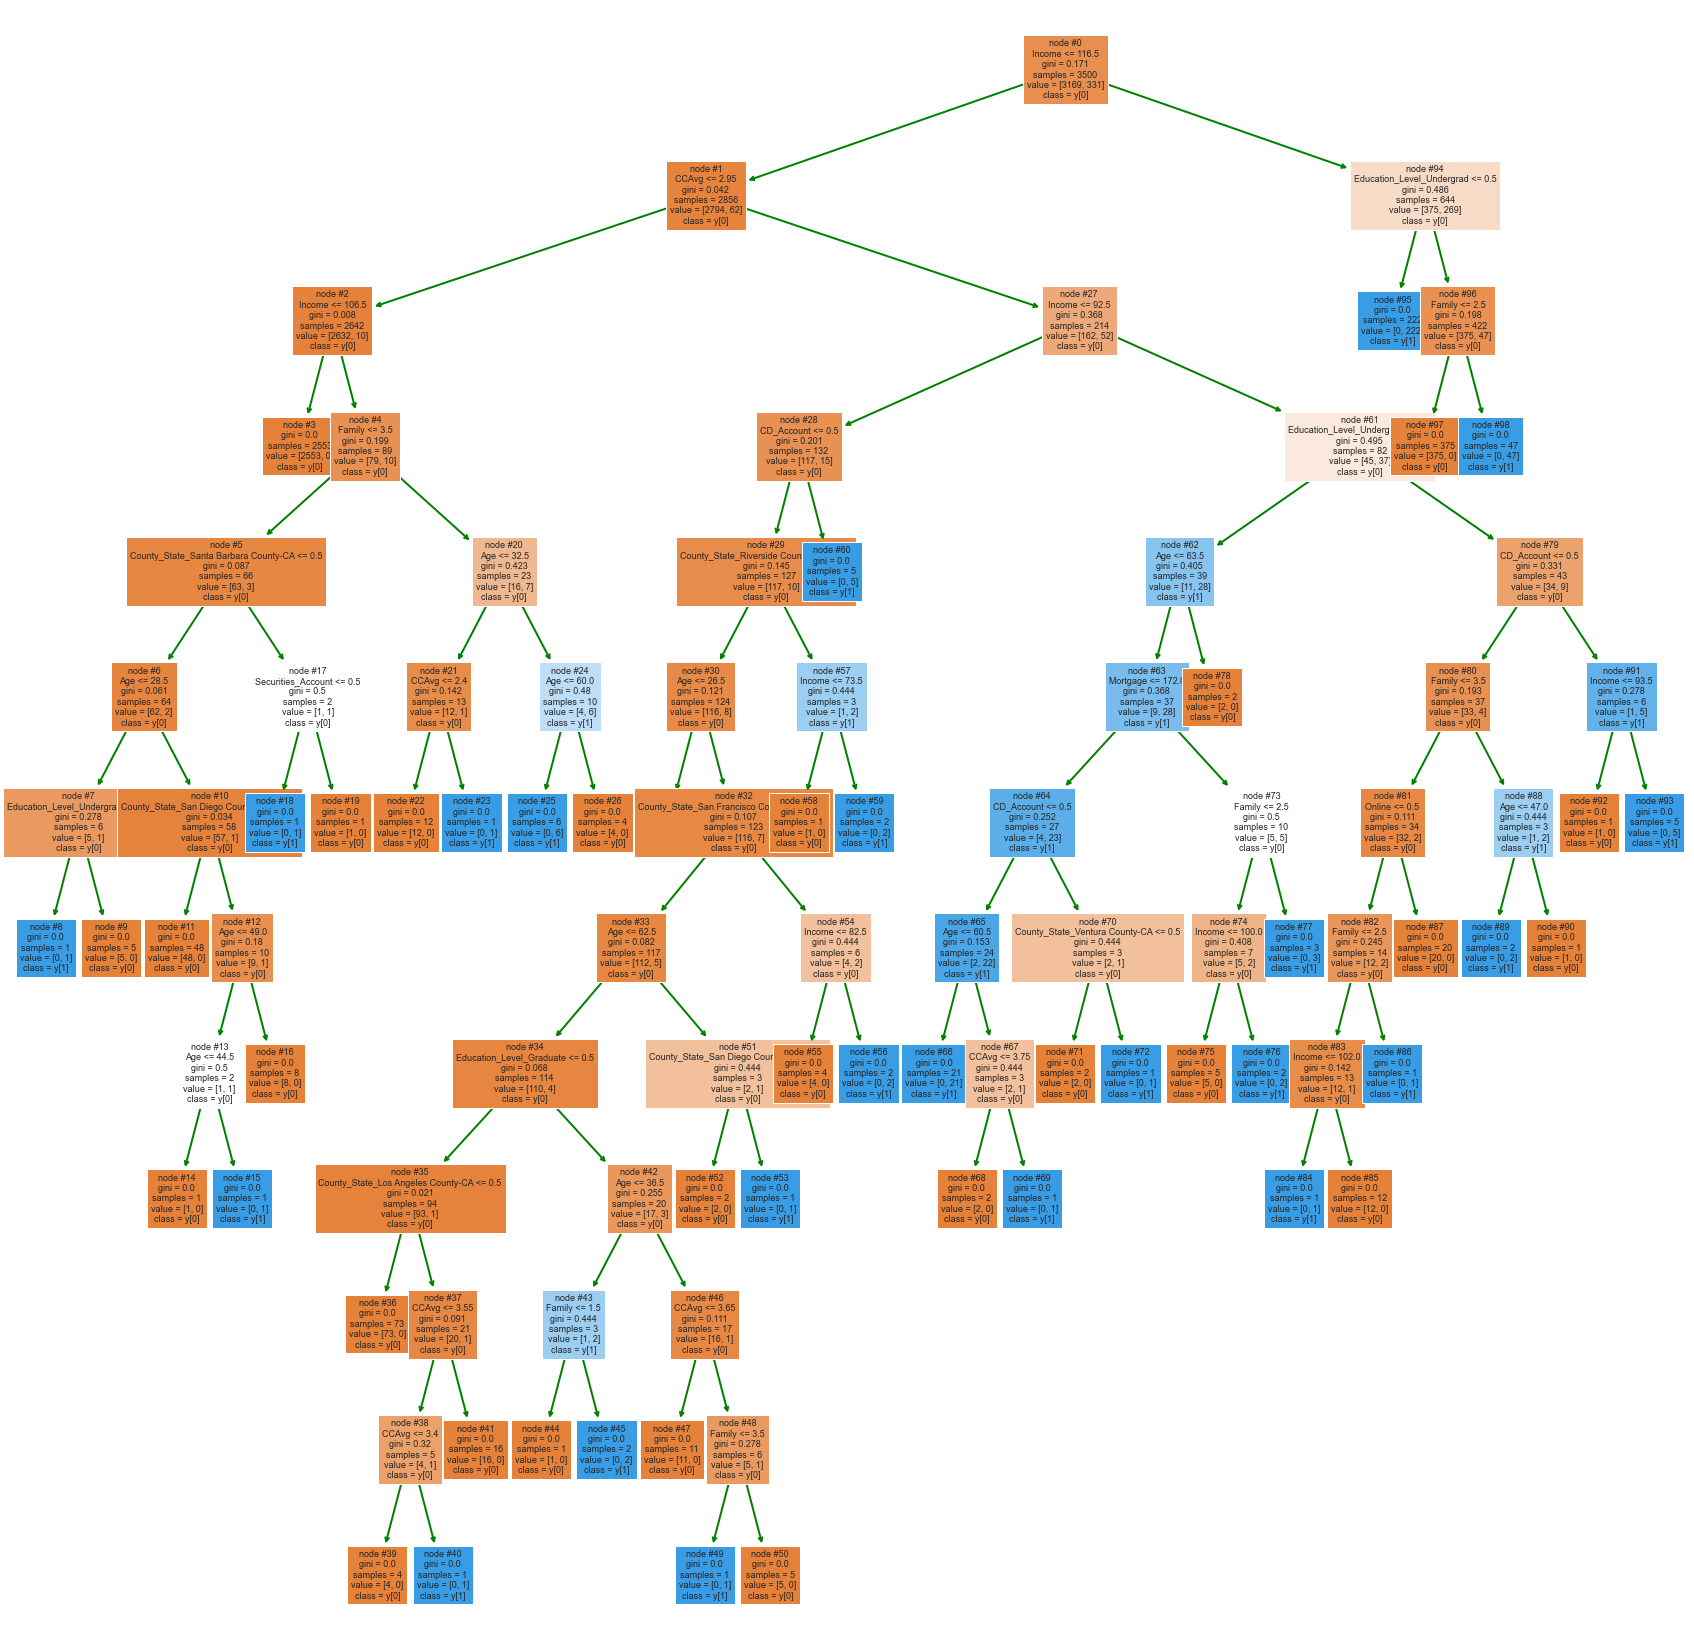

In [102]:
#Ref: https://stackoverflow.com/questions/62318367/decision-tree-edges-branches-so-light-that-are-invisible
fig, ax = plt.subplots(figsize=(30,30))
out = tree.plot_tree(dTree1,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('green')
        arrow.set_linewidth(2)

### Report showing the rules of the decision tree:

In [103]:
print(tree.export_text(dTree1,feature_names=feature_names,show_weights=True))

|--- Income <= 116.50
|   |--- CCAvg <= 2.95
|   |   |--- Income <= 106.50
|   |   |   |--- weights: [2553.00, 0.00] class: 0
|   |   |--- Income >  106.50
|   |   |   |--- Family <= 3.50
|   |   |   |   |--- County_State_Santa Barbara County-CA <= 0.50
|   |   |   |   |   |--- Age <= 28.50
|   |   |   |   |   |   |--- Education_Level_Undergrad <= 0.50
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00] class: 1
|   |   |   |   |   |   |--- Education_Level_Undergrad >  0.50
|   |   |   |   |   |   |   |--- weights: [5.00, 0.00] class: 0
|   |   |   |   |   |--- Age >  28.50
|   |   |   |   |   |   |--- County_State_San Diego County-CA <= 0.50
|   |   |   |   |   |   |   |--- weights: [48.00, 0.00] class: 0
|   |   |   |   |   |   |--- County_State_San Diego County-CA >  0.50
|   |   |   |   |   |   |   |--- Age <= 49.00
|   |   |   |   |   |   |   |   |--- Age <= 44.50
|   |   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Age > 

### Gini importance or mean decrease impurity of a node

In [104]:
print (pd.DataFrame(dTree1.feature_importances_, 
                    columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                                             Imp
Education_Level_Undergrad               0.403732
Income                                  0.315117
Family                                  0.157792
CCAvg                                   0.046638
Age                                     0.033275
CD_Account                              0.025711
County_State_Riverside County-CA        0.003544
Mortgage                                0.003014
County_State_San Diego County-CA        0.002501
County_State_Ventura County-CA          0.002224
Securities_Account                      0.001668
County_State_San Francisco County-CA    0.001608
County_State_Santa Barbara County-CA    0.001422
Education_Level_Graduate                0.001069
Online                                  0.000561
County_State_Los Angeles County-CA      0.000123
County_State_Siskiyou County-CA         0.000000
County_State_San Joaquin County-CA      0.000000
County_State_San Luis Obispo County-CA  0.000000
County_State_San Mat

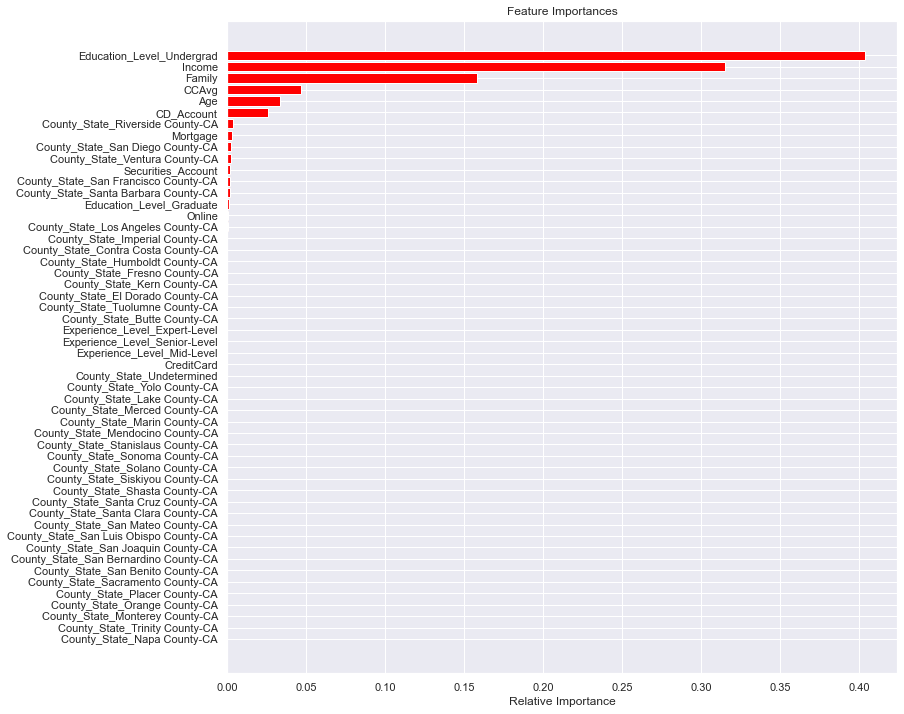

In [105]:
importances = dTree1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Observations
* Top features according to the model are: Undergrad, Income, Family, CC Avg, Age and CD Account.
* The initial decision tree is always overfitted.

## Reducing over fitting (pre-pruning)

### dTree2 - Using GridSearch for Hyperparameter tuning of our tree model

* Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
* It is an exhaustive search that is performed on a the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [106]:
from sklearn.model_selection import GridSearchCV

In [107]:
# Choose the type of classifier. 
dTree2 = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from

parameters = {'max_depth': np.arange(1,10),
              #'criterion': ['gini','entropy'], # try both gini index (easy to compute) and entropy (processor intensive)
              'criterion': ['gini'], # got better results with gini, disregarding entropy.
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(dTree2, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dTree2 = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dTree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, random_state=1)

In [108]:
#Predict on train and test
y_predict_train2 = dTree2.predict(X_train)
y_predict_test2 = dTree2.predict(X_test)

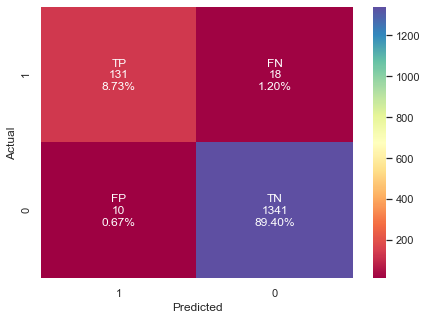

In [109]:
#Confusion matrix on the test set.
draw_confusion_matrix(y_test,y_predict_test2)

In [110]:
# Calculate and save scores for later comparison with other models.
train_score_dt2 = model_scores('dTree2 - Decision Tree w/ pre-pruning GridSearch HP - Train',y_train,y_predict_train2).scores
test_score_dt2  = model_scores('dTree2 - Decision Tree w/ pre-pruning GridSearch HP - Test',y_test,y_predict_test2).scores
add_to_models_scores(train_scores=train_score_dt2,test_scores=test_score_dt2)

In [111]:
print('Decision Tree dTree2 with Pre-pruning Scores')
show_to_model_scores(train_scores=train_score_dt2,test_scores=test_score_dt2)

Decision Tree dTree2 with Pre-pruning Scores
----
Accuracy on train data: 0.9897
Accuracy on test data: 0.9813
----
Recall on train data: 0.9275
Recall on test data: 0.8792
----
Precision on train data: 0.9624
Precision on test data: 0.9291
----
f1 score on train data: 0.9446
f1 score on test data: 0.9034


### Observations
* We can observe an improvement on the recall score for the test set. 
* Also the training and test set scores are both more more aligned.

## Visualizing the Decision Tree

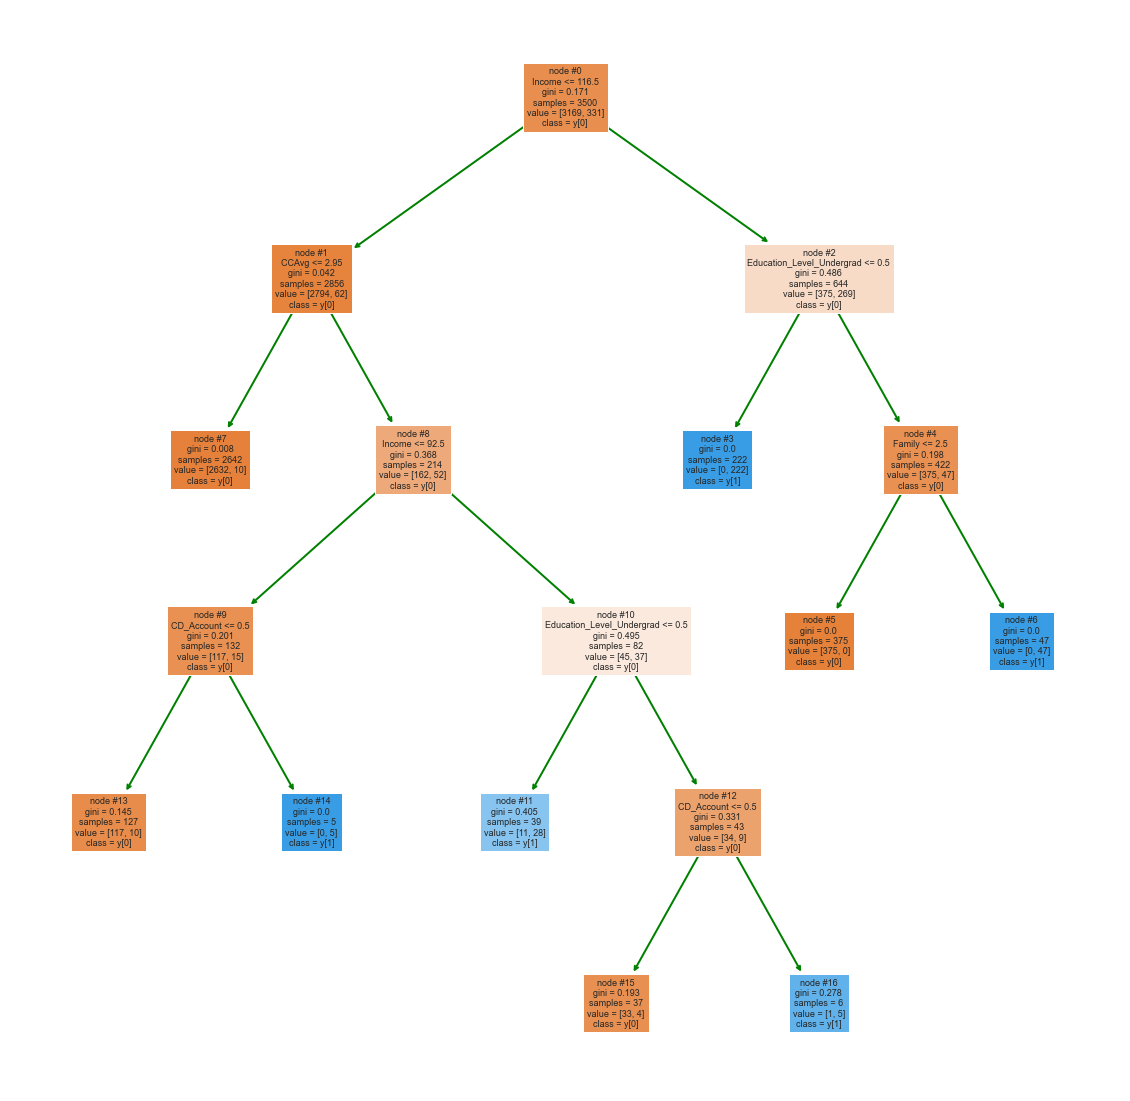

In [112]:
#Ref: https://stackoverflow.com/questions/62318367/decision-tree-edges-branches-so-light-that-are-invisible
fig, ax = plt.subplots(figsize=(20,20))
out = tree.plot_tree(dTree2,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('green')
        arrow.set_linewidth(2)

### Observation
* The result is a much simplier decision tree after using the hyperparameters and yet resulting in a better recall score on the test set.

In [113]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the 'criterion' brought by that feature. It is also known as the Gini importance )
pdImp = pd.DataFrame(dTree2.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False)
print(pdImp[pdImp.Imp>0])
#Here we will see that importance of features has increased

                                Imp
Education_Level_Undergrad  0.447999
Income                     0.328713
Family                     0.155711
CCAvg                      0.042231
CD_Account                 0.025345


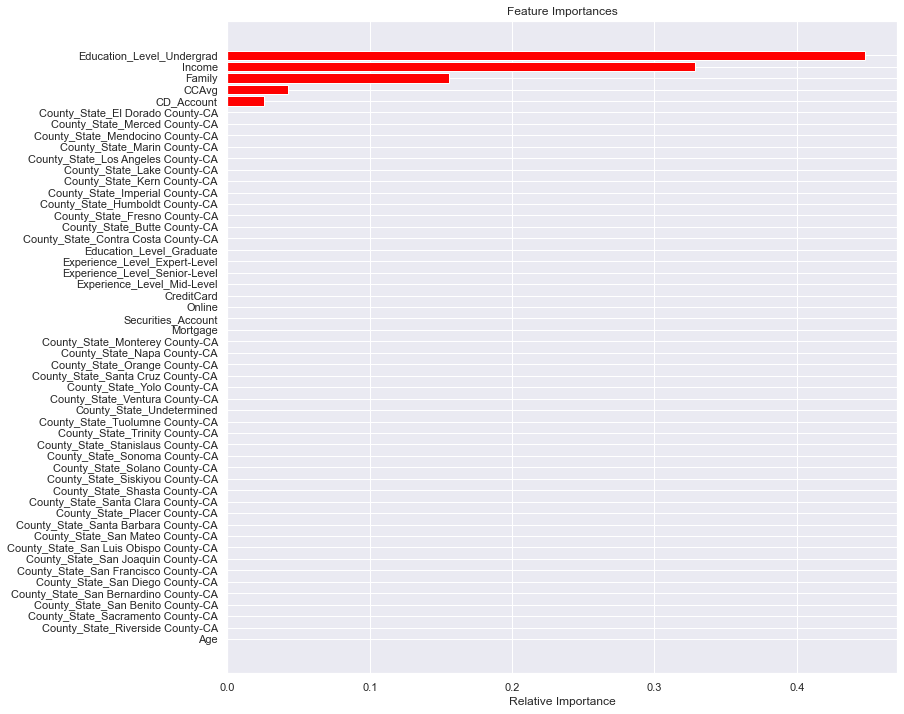

In [114]:
importances = dTree2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* Important Features: Education_Level_Undergrad, Income, Family, CCAvg, CD_Account.

## Reducing over fitting (post-pruning)

### Cost Complexity Pruning

In addition to the decision tree classifier, will now test cost complexity pruning to control the size of the tree to prevent overfitting.

In [115]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [116]:
pd.DataFrame(path)

ccp_alphas  impurities
0     0.000000    0.000000
1     0.000187    0.000562
2     0.000188    0.001127
3     0.000269    0.002202
4     0.000269    0.002740
5     0.000326    0.004371
6     0.000359    0.005447
7     0.000381    0.005828
8     0.000381    0.006209
9     0.000381    0.006590
10    0.000381    0.006971
11    0.000476    0.007447
12    0.000514    0.008988
13    0.000527    0.009516
14    0.000582    0.010098
15    0.000593    0.011283
16    0.000607    0.011890
17    0.000641    0.014456
18    0.000882    0.017985
19    0.001552    0.019536
20    0.002333    0.021869
21    0.003024    0.024893
22    0.003294    0.028187
23    0.006473    0.034659
24    0.023866    0.058525
25    0.056365    0.171255

* The greater the ccp_alpha, the greater the number of nodes pruned, which will increase the total inpurity of its leaves.
* Will use nodes with the smallest effective alpha to prune first.

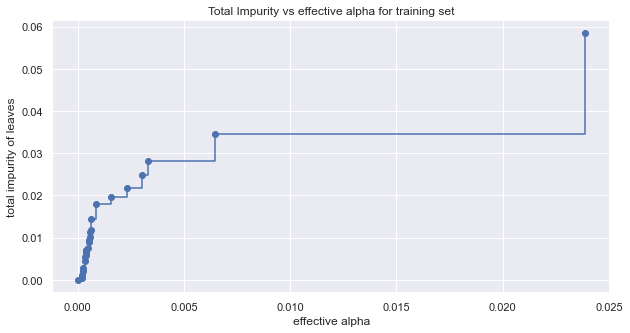

In [120]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

#### Training the decision tree using the effective alphas.

In [121]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha,class_weight = "balanced")#{0:0.15,1:0.85}"")
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.056364969335601575


#### Number of nodes vs tree depth.

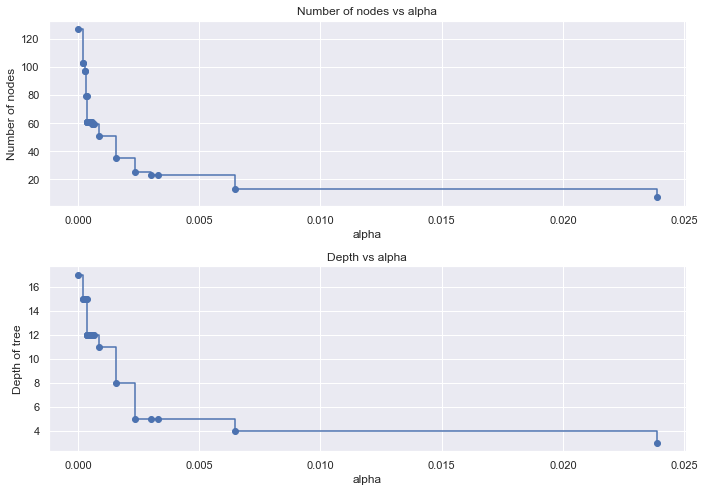

In [122]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

* As alpha increases, the number of nodes and tree depth decreases.

### Recall vs alpha using both training and testing sets

In [123]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)

In [124]:
pd.DataFrame(recall_train).sample(n=5)

0
17  1.0
0   1.0
22  1.0
6   1.0
15  1.0

In [125]:
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_test)
    values_test=metrics.recall_score(y_test,pred_test3)
    recall_test.append(values_test)

In [126]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

### Plotting Recall vs Alpha

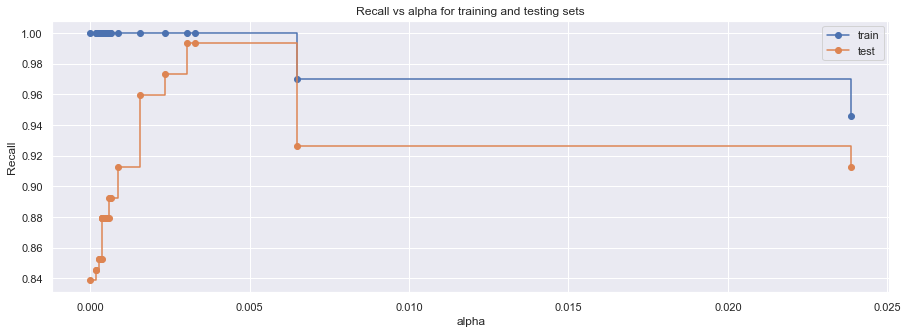

In [127]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post",)
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### dTree3 - Creating the model where we get highest train and test recall

In [128]:
index_best_model = np.argmax(recall_test)
dTree3 = clfs[index_best_model]
dTree3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.003023521760901227, class_weight='balanced',
                       random_state=1)

In [129]:
dTree3.ccp_alpha

0.003023521760901227

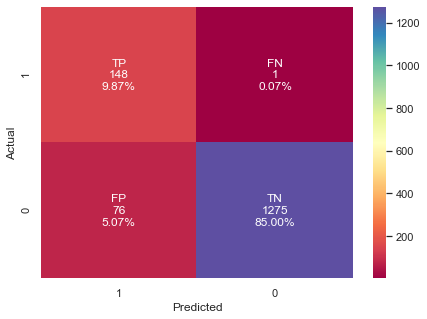

In [130]:
#Confusion matrix on the test set.
y_predict_train3 = dTree3.predict(X_train)
y_predict_test3 = dTree3.predict(X_test)
draw_confusion_matrix(y_test,y_predict_test3)

In [131]:
get_recall_score(dTree3)
print('Precision on training set:',float("{:.4f}".format(precision_score(y_train, y_predict_train3))))
print('Precision on test set:',float("{:.4f}".format(precision_score(y_test, y_predict_test3))))

Recall on training set :  1.0
Recall on test set :  0.9932885906040269
Precision on training set: 0.6867
Precision on test set: 0.6607


In [132]:
# Calculate and save scores for later comparison with other models.
train_score_dt3 = model_scores('dTree3 - Decision Tree w/ post-pruning (alpha=0.006)- Train',y_train,y_predict_train3).scores
test_score_dt3  = model_scores('dTree3 - Decision Tree w/ post-pruning (alpha=0.006)- Test',y_test,y_predict_test3).scores
add_to_models_scores(train_scores=train_score_dt3,test_scores=test_score_dt3)

In [133]:
print('Decision Tree dTree3 with Pre-pruning Scores')
show_to_model_scores(train_scores=train_score_dt3,test_scores=test_score_dt3)

Decision Tree dTree3 with Pre-pruning Scores
----
Accuracy on train data: 0.9569
Accuracy on test data: 0.9487
----
Recall on train data: 1.0
Recall on test data: 0.9933
----
Precision on train data: 0.6867
Precision on test data: 0.6607
----
f1 score on train data: 0.8143
f1 score on test data: 0.7936


### Visualizing the decision tree

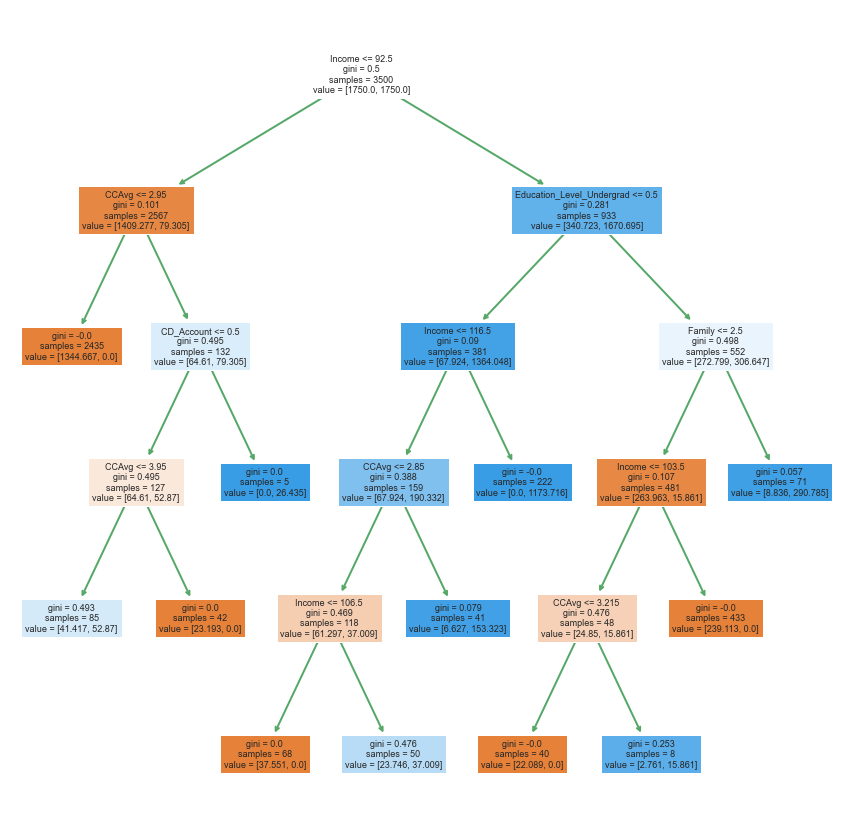

In [134]:
plt.figure(figsize=(15,15))

out = tree.plot_tree(dTree3,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('g')
        arrow.set_linewidth(2)
plt.show()

In [135]:
# Text report showing the rules of a decision tree -

print(tree.export_text(dTree3,feature_names=feature_names,show_weights=True))

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1344.67, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- CCAvg <= 3.95
|   |   |   |   |--- weights: [41.42, 52.87] class: 1
|   |   |   |--- CCAvg >  3.95
|   |   |   |   |--- weights: [23.19, 0.00] class: 0
|   |   |--- CD_Account >  0.50
|   |   |   |--- weights: [0.00, 26.44] class: 1
|--- Income >  92.50
|   |--- Education_Level_Undergrad <= 0.50
|   |   |--- Income <= 116.50
|   |   |   |--- CCAvg <= 2.85
|   |   |   |   |--- Income <= 106.50
|   |   |   |   |   |--- weights: [37.55, 0.00] class: 0
|   |   |   |   |--- Income >  106.50
|   |   |   |   |   |--- weights: [23.75, 37.01] class: 1
|   |   |   |--- CCAvg >  2.85
|   |   |   |   |--- weights: [6.63, 153.32] class: 1
|   |   |--- Income >  116.50
|   |   |   |--- weights: [0.00, 1173.72] class: 1
|   |--- Education_Level_Undergrad >  0.50
|   |   |--- Family <= 2.50
|   |   |   |--- Income <= 103.50
|   |   |   |   |

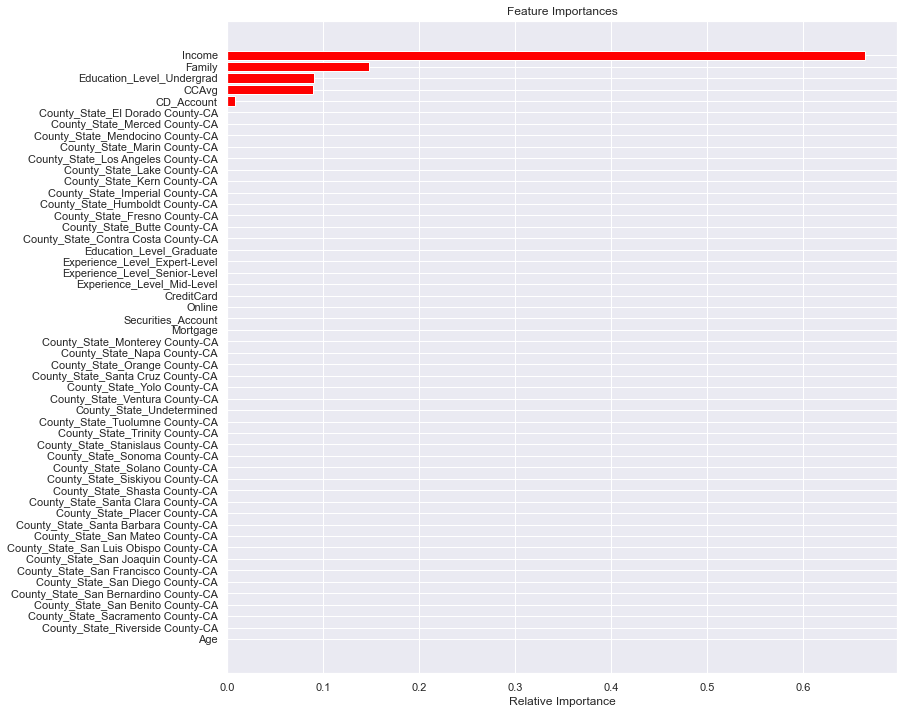

In [136]:
importances = dTree3.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Observation:
* Cost complexity reduction in this last model resulted in too  much pruning.
* Which removed an important feature: CD_Account.
* We will try a new model with an alpha of 0.003 (refer to recall vs alpha plot below to visualize)

### dTree4 - Trying a new model with an alpha of 0.003

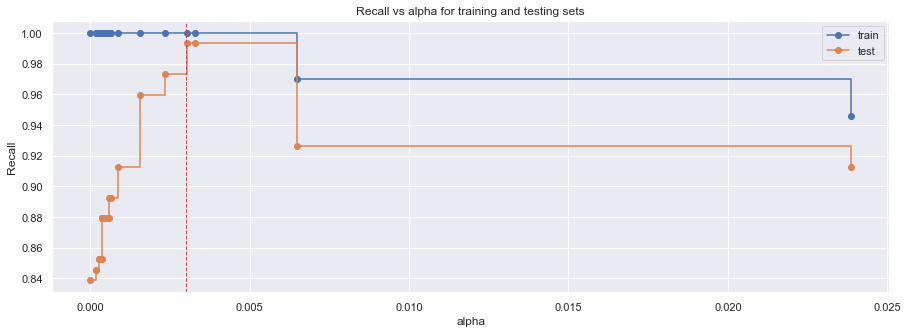

In [139]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post",)
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.axvline(x=0.003,linewidth=1,color='r', linestyle='--', label='alpha')   
plt.show()

In [140]:
# creating the model with a 0.003 alpha instead.
dTree4 = DecisionTreeClassifier(ccp_alpha=0.003,
                       class_weight="balanced", random_state=1)         
                       #class_weight={0: 0.15, 1: 0.85}, random_state=1)
dTree4.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.003, class_weight='balanced', random_state=1)

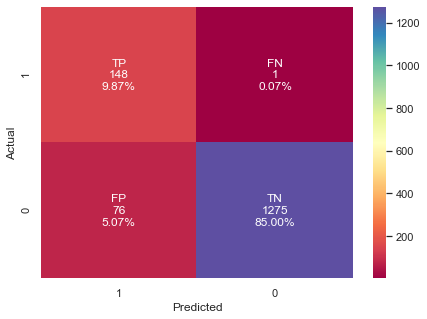

In [141]:
#Confusion matrix on the test set.
y_predict_train4 = dTree4.predict(X_train)
y_predict_test4 = dTree4.predict(X_test)

draw_confusion_matrix(y_test,y_predict_test4)

In [142]:
# Calculate and save scores for later comparison with other models.
train_score_dt4 = model_scores('dTree4 - Decision Tree w/ post-pruning (alpha=0.003)- Train',y_train,y_predict_train4).scores
test_score_dt4  = model_scores('dTree4 - Decision Tree w/ post-pruning (alpha=0.003)- Test',y_test,y_predict_test4).scores
add_to_models_scores(train_scores=train_score_dt4,test_scores=test_score_dt4)

In [143]:
get_recall_score(dTree4)
print('Precision on training set:',float("{:.4f}".format(precision_score(y_train, y_predict_train4))))
print('Precision on test set:',float("{:.4f}".format(precision_score(y_test, y_predict_test4))))

Recall on training set :  1.0
Recall on test set :  0.9932885906040269
Precision on training set: 0.6867
Precision on test set: 0.6607


In [144]:
print('Decision Tree dTree4 with Post-pruning (alpha=0.003) Scores')
show_to_model_scores(train_scores=train_score_dt4,test_scores=test_score_dt4)

Decision Tree dTree4 with Post-pruning (alpha=0.003) Scores
----
Accuracy on train data: 0.9569
Accuracy on test data: 0.9487
----
Recall on train data: 1.0
Recall on test data: 0.9933
----
Precision on train data: 0.6867
Precision on test data: 0.6607
----
f1 score on train data: 0.8143
f1 score on test data: 0.7936


### Visualizing the Decision Tree

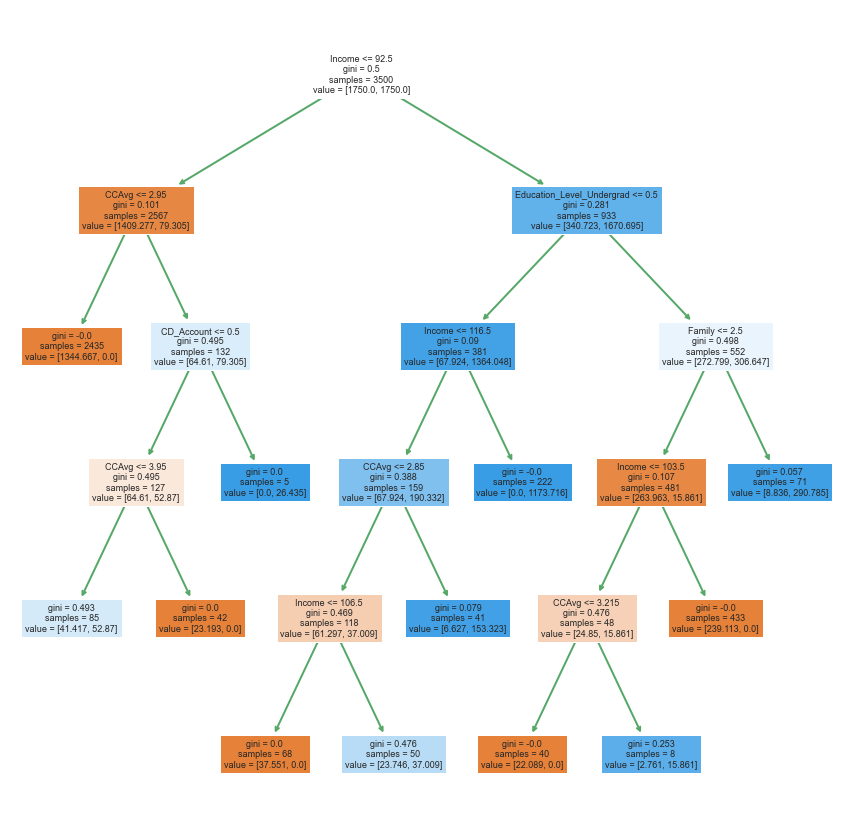

In [145]:
plt.figure(figsize=(15,15))

out = tree.plot_tree(dTree4,feature_names=feature_names,filled=True,fontsize=9,node_ids=False,class_names=None)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('g')
        arrow.set_linewidth(2)
plt.show()

In [146]:
# Text report showing the rules of a decision tree.
print(tree.export_text(dTree4,feature_names=feature_names,show_weights=True))

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1344.67, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- CD_Account <= 0.50
|   |   |   |--- CCAvg <= 3.95
|   |   |   |   |--- weights: [41.42, 52.87] class: 1
|   |   |   |--- CCAvg >  3.95
|   |   |   |   |--- weights: [23.19, 0.00] class: 0
|   |   |--- CD_Account >  0.50
|   |   |   |--- weights: [0.00, 26.44] class: 1
|--- Income >  92.50
|   |--- Education_Level_Undergrad <= 0.50
|   |   |--- Income <= 116.50
|   |   |   |--- CCAvg <= 2.85
|   |   |   |   |--- Income <= 106.50
|   |   |   |   |   |--- weights: [37.55, 0.00] class: 0
|   |   |   |   |--- Income >  106.50
|   |   |   |   |   |--- weights: [23.75, 37.01] class: 1
|   |   |   |--- CCAvg >  2.85
|   |   |   |   |--- weights: [6.63, 153.32] class: 1
|   |   |--- Income >  116.50
|   |   |   |--- weights: [0.00, 1173.72] class: 1
|   |--- Education_Level_Undergrad >  0.50
|   |   |--- Family <= 2.50
|   |   |   |--- Income <= 103.50
|   |   |   |   |

### Features Importance

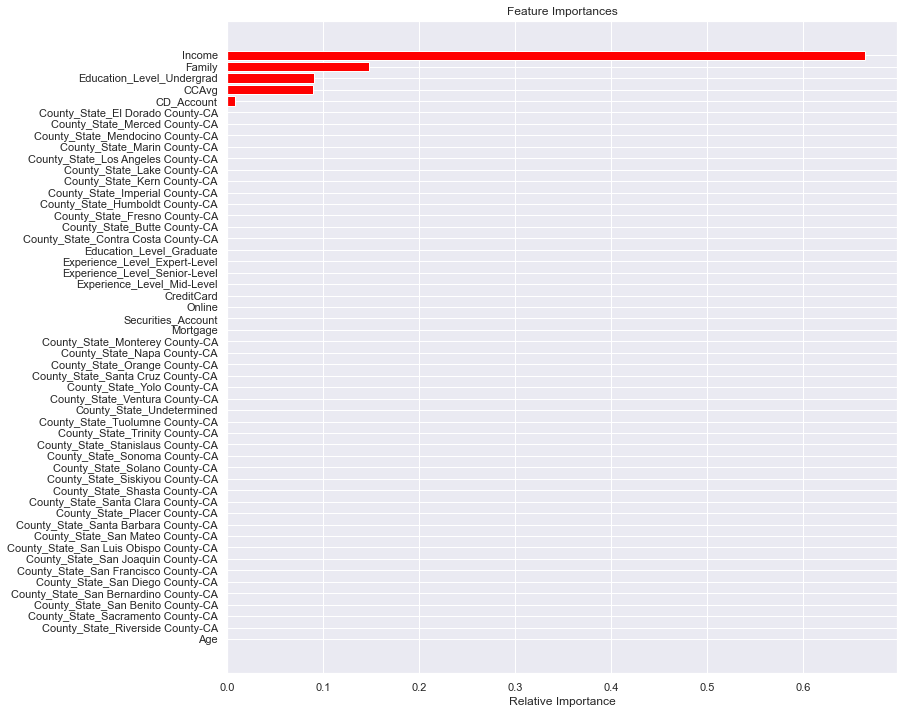

In [147]:
importances = dTree4.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Observation:

* It can be observed that in this latest model, choosing a smaller optimal alpha, the infomation for the important features has been retained at the same time the model reduced overfitting even further compared with the previous model at a very small cost to recall, but with a higher improvement in precision. which resulted in an overall better model.

### Comparing all the decision tree models

In [148]:
pd.set_option('display.max_colwidth', None)
m = all_models_scores.copy()
comparison_train = pd.DataFrame(
    {'Model':[     
                    m[0]['name'],m[2]['name'],m[4]['name'],
                    m[6]['name'],m[8]['name'],m[10]['name'],m[12]['name'],
             ],                                   
     'Accuracy' :[
                    m[0]['accuracy'],m[2]['accuracy'],m[4]['accuracy'],
                    m[6]['accuracy'],m[8]['accuracy'],m[10]['accuracy'],m[12]['accuracy'],
                 ], 
     'Recall'   :[
                    m[0]['recall'],m[2]['recall'],m[4]['recall'],
                    m[6]['recall'],m[8]['recall'],m[10]['recall'],m[12]['recall'],
                 ], 
     'Precision':[
                    m[0]['precision'],m[2]['precision'],m[4]['precision'],
                    m[6]['precision'],m[8]['precision'],m[10]['precision'],m[12]['precision'],
                 ],                                       
     'F1':       [
                    m[0]['f1'],m[2]['f1'],m[4]['f1'],
                    m[6]['f1'],m[8]['f1'],m[10]['f1'],m[12]['f1'],
                 ],                                          
    }) 

comparison_test = pd.DataFrame(
    {'Model':[     
                    m[1]['name'],m[3]['name'],m[5]['name'],
                    m[7]['name'],m[9]['name'],m[11]['name'],m[13]['name'],
             ],                                   
     'Accuracy' :[
                    m[1]['accuracy'],m[3]['accuracy'],m[5]['accuracy'],
                    m[7]['accuracy'],m[9]['accuracy'],m[11]['accuracy'],m[13]['accuracy']
                 ], 
     'Recall'   :[
                    m[1]['recall'],m[3]['recall'],m[5]['recall'],
                    m[7]['recall'],m[9]['recall'],m[11]['recall'],m[13]['recall']
                 ], 
     'Precision':[
                    m[1]['precision'],m[3]['precision'],m[5]['precision'],
                    m[7]['precision'],m[9]['precision'],m[11]['precision'],m[13]['precision']
                 ],                                       
     'F1':       [
                    m[1]['f1'],m[3]['f1'],m[5]['f1'],
                    m[7]['f1'],m[9]['f1'],m[11]['f1'],m[13]['f1']
                 ],                                          
    }) 

In [149]:
comparison_train

Model  Accuracy  \
0              lg1 - Logistic Regression - Initial Model - Train    0.9640   
1          lg2 - Logistic Regression - w/o n.s. features - Train    0.9649   
2  lg2 - Logistic Regression - ROC-AUC optimal-threshold - Train    0.9329   
3                 dTree1 - Decision Tree - Initial Model - Train    1.0000   
4    dTree2 - Decision Tree w/ pre-pruning GridSearch HP - Train    0.9897   
5    dTree3 - Decision Tree w/ post-pruning (alpha=0.006)- Train    0.9569   
6    dTree4 - Decision Tree w/ post-pruning (alpha=0.003)- Train    0.9569   

   Recall  Precision      F1  
0  0.6966     0.8893  0.7812  
1  0.6997     0.8968  0.7861  
2  0.8793     0.5917  0.7073  
3  1.0000     1.0000  1.0000  
4  0.9275     0.9624  0.9446  
5  1.0000     0.6867  0.8143  
6  1.0000     0.6867  0.8143

In [150]:
comparison_test

Model  Accuracy  \
0              lg1 - Logistic Regression - Initial Model - Test    0.9613   
1          lg2 - Logistic Regression - w/o n.s. features - Test    0.9633   
2  lg2 - Logistic Regression - ROC-AUC optimal-threshold - Test    0.9280   
3                 dTree1 - Decision Tree - Initial Model - Test    0.9760   
4    dTree2 - Decision Tree w/ pre-pruning GridSearch HP - Test    0.9813   
5    dTree3 - Decision Tree w/ post-pruning (alpha=0.006)- Test    0.9487   
6    dTree4 - Decision Tree w/ post-pruning (alpha=0.003)- Test    0.9487   

   Recall  Precision      F1  
0  0.7325     0.8779  0.7986  
1  0.7452     0.8864  0.8097  
2  0.8917     0.6061  0.7216  
3  0.8658     0.8897  0.8776  
4  0.8792     0.9291  0.9034  
5  0.9933     0.6607  0.7936  
6  0.9933     0.6607  0.7936

## EDA on incorrected predicted data on the selected model

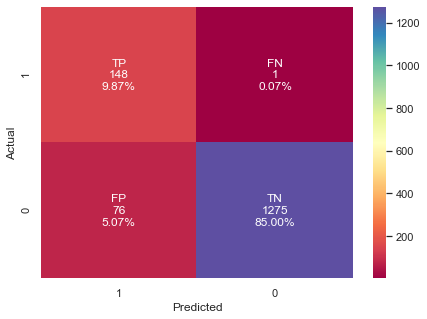

In [151]:
draw_confusion_matrix(y_test,y_predict_test4)

* The total of **true negatives (TP) - class 0**  captured is 1295/1,500 customers in the test data predicted is 86.3%.

* The total of **true positives (TP) - class 1**  captured is 138/1,500 customers in the test data predicted is 9.2%.

* The total of **false negatives (FN)** captured is 11/1,500 customers in the test data predicted was only 0.73%, which explains the high recall rate.

* The total of **false positives (FP)** captured is 56/1,500 customers in the test data predicted was only 3.73%, which explains the precision rate.

### Using the model selected to predict on the full dataset.

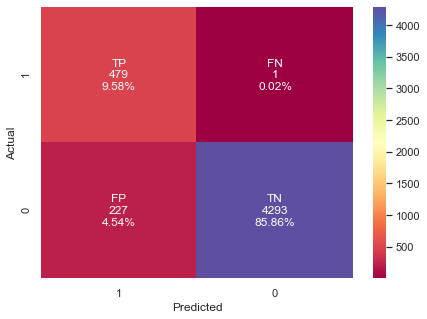

In [152]:
#Predict on the original data set.
y_predict_full_data = dTree4.predict(X)
#Confusion matrix on original data set.
draw_confusion_matrix(y,y_predict_full_data)

In [153]:
#combining the original data and adding y_predict
df_combined = X.copy(deep=True)
df_combined['Personal_Loan'] = y #original values
df_combined['Personal_Loan_Predicted'] = y_predict_full_data # predicted values

In [154]:
df_combined.sample(n=5)

Age  Income  Family  CCAvg  Mortgage  Securities_Account  CD_Account  \
3684   57      51       4   1.70       103                   0           0   
132    31      51       2   1.75         0                   0           0   
3662   35     164       2   0.00       500                   0           0   
278    50      21       4   1.00         0                   0           0   
4242   46      68       1   0.20         0                   0           0   

      Online  CreditCard  Experience_Level_Mid-Level  ...  \
3684       1           0                           0  ...   
132        0           0                           0  ...   
3662       0           0                           1  ...   
278        1           0                           0  ...   
4242       1           0                           0  ...   

      County_State_Stanislaus County-CA  County_State_Trinity County-CA  \
3684                                  0                               0   
132                                   0                               0   
3662                                  0                               0   
278                                   0                               0   
4242                                  0                               0   

      County_State_Tuolumne County-CA  County_State_Undetermined  \
3684                                0                          0   
132                                 0                          0   
3662                                0                          0   
278                                 0                          0   
4242                                0                          0   

      County_State_Ventura County-CA  County_State_Yolo County-CA  \
3684                               0                            0   
132                                0                            0   
3662                               0                            0   
278                                0                            0   
4242                               0                            0   

      Education_Level_Graduate  Education_Level_Undergrad  Personal_Loan  \
3684                         1                          0              0   
132                          0                          0              0   
3662                         0                          1              0   
278                          0                          1              0   
4242                         1                          0              0   

      Personal_Loan_Predicted  
3684                        0  
132                         0  
3662                        0  
278                         0  
4242                        0  

[5 rows x 54 columns]

### Ptotting Actual vs Predicted

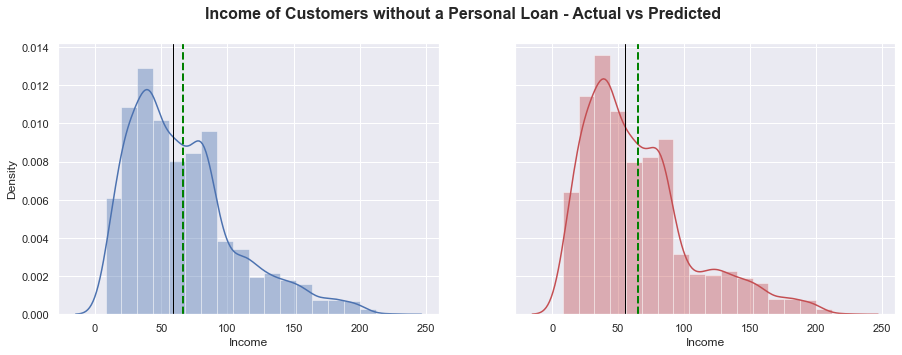

In [155]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.distplot(df_combined[df_combined['Personal_Loan']==0].Income, bins=18,                  
                  label = 'Customer without a personal loan', ax = ax1, kde =True,color='b')

ax2 = sns.distplot(df_combined[df_combined['Personal_Loan_Predicted']==0].Income, bins=18, 
                  label = 'Customer without a personal loan', ax = ax2, kde =True,color='r')
plt.suptitle('Income of Customers without a Personal Loan - Actual vs Predicted',fontsize=16,fontweight="bold")

ax1.axvline(
        df_combined[df_combined['Personal_Loan']==0].Income.mean(), label="Mean",
        color="green", linestyle="--", linewidth=2)
ax1.axvline(
        df_combined[df_combined['Personal_Loan']==0].Income.quantile(q=0.5), label="Median",
        color="black", linestyle="-", linewidth=1)
ax2.axvline(
        df_combined[df_combined['Personal_Loan_Predicted']==0].Income.mean(), label="Mean",
        color="green", linestyle="--", linewidth=2)
ax2.axvline(
        df_combined[df_combined['Personal_Loan_Predicted']==0].Income.quantile(q=0.5), label="Median",
        color="black", linestyle="-", linewidth=1)
plt.show()

### Observations:
* The income distribution for those without a personal loan are very similar as expected due to the high recall score on the model.
* Those making less than $98.5K are more likely to purchase a loan.

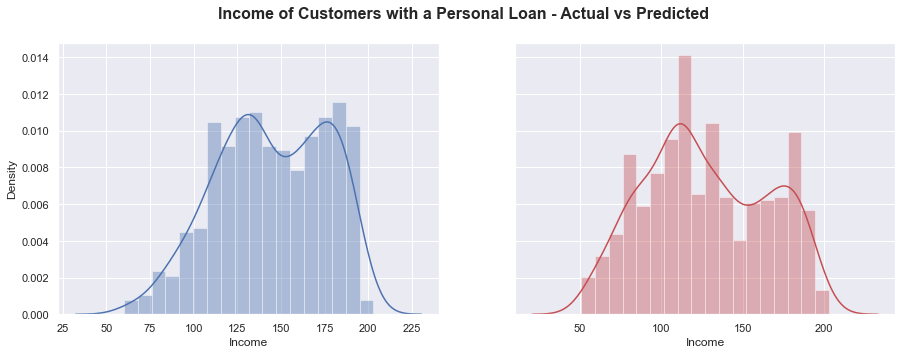

In [156]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax = sns.distplot(df_combined[df_combined['Personal_Loan']==1].Income, bins=18,                  
                  label = 'Customer with a personal loan', ax = ax1, kde =True,color='b')

ax = sns.distplot(df_combined[df_combined['Personal_Loan_Predicted']==1].Income, bins=18, 
                  label = 'Customer with a personal loan', ax = ax2, kde =True,color='r')
plt.suptitle('Income of Customers with a Personal Loan - Actual vs Predicted',fontsize=16,fontweight="bold")
plt.show()

### Observations:
* Customers making less than $98.5K/yr is less likely to obtain a loan.

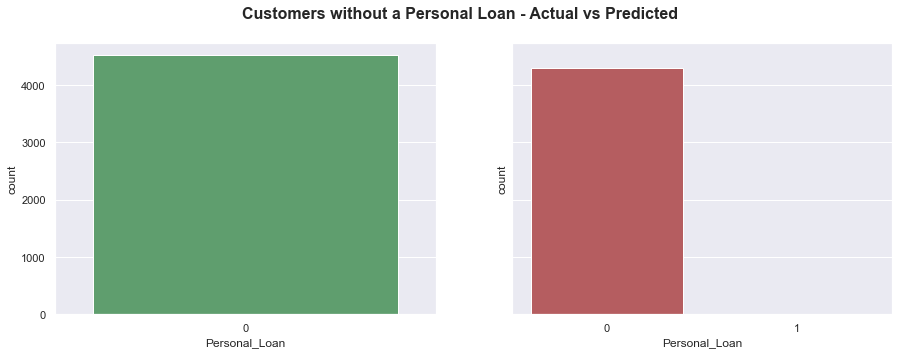

In [157]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(df_combined[df_combined['Personal_Loan']==0].Personal_Loan, 
                  label = 'Customer has a personal loan', ax = ax1,color='g')

ax2 = sns.countplot(df_combined[df_combined['Personal_Loan_Predicted']==0].Personal_Loan, 
                  label = 'Customer does not have a personal loan', ax = ax2,color='r')

plt.suptitle('Customers without a Personal Loan - Actual vs Predicted',fontsize=16,fontweight="bold")
plt.show()

### Observations:
* As expected the number of FN is almost none due to the model high recall score.

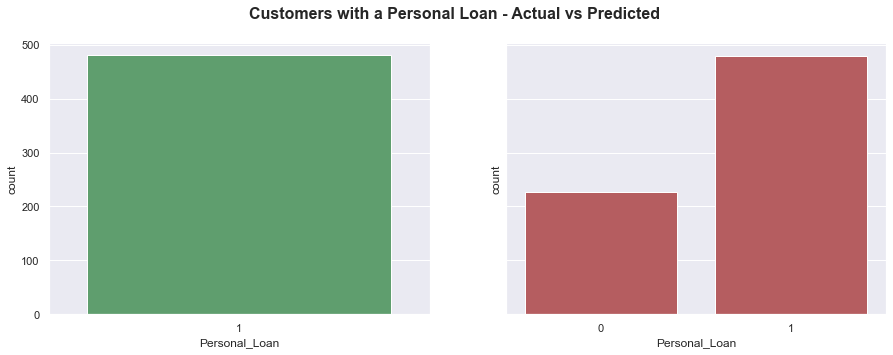

In [158]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(df_combined[df_combined['Personal_Loan']==1].Personal_Loan, 
                  label = 'Customer has a personal loan', ax = ax1,color='g')

ax2 = sns.countplot(df_combined[df_combined['Personal_Loan_Predicted']==1].Personal_Loan, 
                  label = 'Customer does not have a personal loan', ax = ax2,color='r')

plt.suptitle('Customers with a Personal Loan - Actual vs Predicted',fontsize=16,fontweight="bold")
plt.show()

### Observations:
* As expected per model precision score, the number of FP is low.

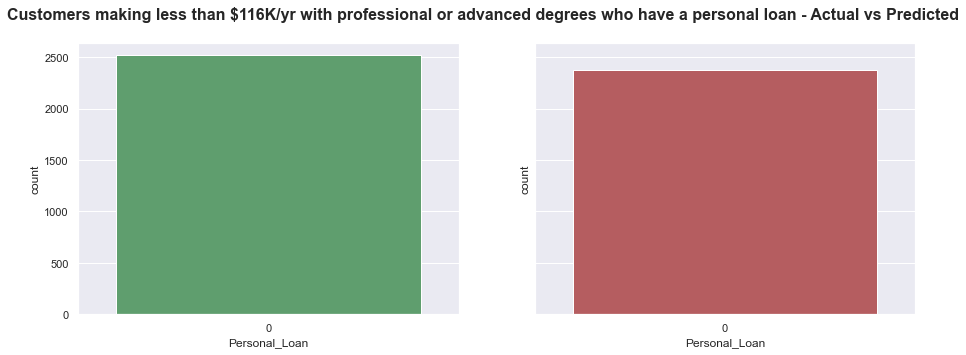

In [159]:
actual    = df_combined[(df_combined['Personal_Loan']==0) &
                        (df_combined['Income']<=116) &                        
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

predicted = df_combined[(df_combined['Personal_Loan_Predicted']==0) &
                        (df_combined['Income']<=116) &
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(actual, ax = ax1,color='g')
ax2 = sns.countplot(predicted, ax = ax2,color='r')
plt.suptitle(
'Customers making less than \$116K/yr with professional or advanced degrees who have a personal loan - Actual vs Predicted'
,fontsize=16,fontweight="bold")
plt.show()

### Observations:
* Potential business opportunity on customers making less than $116K/yr with professional or advanced degrees who do not have a personal loan.
 

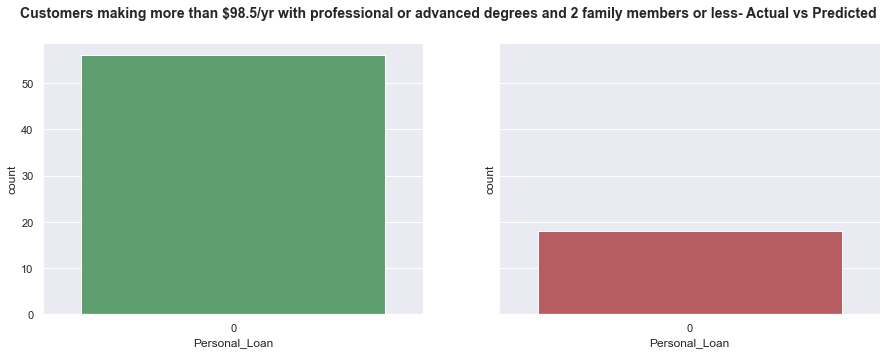

In [160]:
actual    = df_combined[(df_combined['Personal_Loan']==0) &
                        (df_combined['Family']<=2) &
                        (df_combined['Income']>=98.5) &
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

predicted = df_combined[(df_combined['Personal_Loan_Predicted']==0) &
                        (df_combined['Family']<=2) &
                        (df_combined['Income']>=98.5) &
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(actual, ax = ax1,color='g')
ax2 = sns.countplot(predicted, ax = ax2,color='r')
plt.suptitle(
'Customers making more than \$98.5/yr with professional or advanced degrees and 2 family members or less- Actual vs Predicted'
,fontsize=14,fontweight="bold")
plt.show()

### Observations:
* There is some business opportunity but with a relative higher (although small) level of prediction uncertainty (False Positives) on loan purchase by customers making more than \$98.5/yr with a professional or advanced degrees and 2 family members or less.

* This can be visualized on the decision tree gini index.

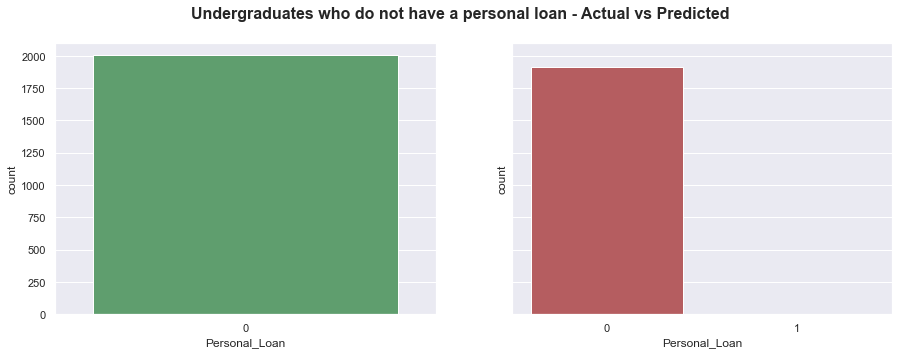

In [161]:
actual    = df_combined[(df_combined['Personal_Loan']==0) &
                        (df_combined['Education_Level_Undergrad']==1)].Personal_Loan
predicted = df_combined[(df_combined['Personal_Loan_Predicted']==0) &
                        (df_combined['Education_Level_Undergrad']==1)].Personal_Loan

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(actual, ax = ax1, color='g')
ax2 = sns.countplot(predicted, ax = ax2, color='r')
plt.suptitle('Undergraduates who do not have a personal loan - Actual vs Predicted',fontsize=16,fontweight="bold")
plt.show()

#### Customers with an income greater than 116K and advanced or professional degree without a personal loan

In [162]:
# Customers with an income greater than 116K and advanced or professional degree without a personal loan
actual    = df_combined[(df_combined['Personal_Loan']==0) &
                        (df_combined['Income']>=116) &                        
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

predicted = df_combined[(df_combined['Personal_Loan_Predicted']==0) &
                        (df_combined['Income']>=116) &
                        (df_combined['Education_Level_Undergrad']==0)].Personal_Loan

print('Actual:',len(actual))
print('Predicted:',len(predicted))

Actual: 0
Predicted: 0


### Observations:
* There are no customers with an income greater than \$116K and with an advanced or professional degree without a personal loan.
* This can be observed in the decision tree with a good certainty.

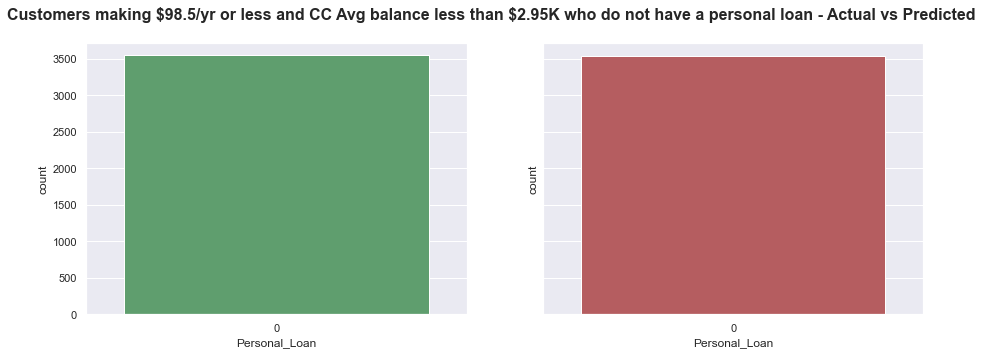

In [163]:
actual    = df_combined[(df_combined['Personal_Loan']==0) &
                        (df_combined['CCAvg']<=2.95) &
                        (df_combined['Income']<=98.5)].Personal_Loan

predicted = df_combined[(df_combined['Personal_Loan_Predicted']==0) &
                        (df_combined['CCAvg']<=2.95) &
                        (df_combined['Income']<=98.5)].Personal_Loan

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
ax1 = sns.countplot(actual, ax = ax1,color='g')
ax2 = sns.countplot(predicted, ax = ax2,color='r')
plt.suptitle(
    'Customers making \$98.5/yr or less and CC Avg balance less than $2.95K who do not have a personal loan - Actual vs Predicted'
    ,fontsize=16,fontweight="bold")
plt.show()

### Observations:

* As expected the number of FN is almost none due to the model high recall score and purity of the left branch (Left L1 and L2 nodes gini scores)
* Potential business those making less than 98.5K and a CC Avg balance of less than $ 2.95K

### Conclusion

* The best logistic model is lg2 - Logistic Regression - ROC-AUC optimal-threshold: recall 89%
* Although dTree4 has slight smaller recall (Δ ~ -0.0067) when compared to dTree3, the precision has a relative higher gain (Δ ~ +0.0374) score is much
* **Therefore the best decision tree model is dTree4 - Decision Tree w/ post-pruning (alpha=0.003) with a recall score of 92.6% on the test data.**

### Conclusions

* Multiple different techniques have been used on both logistic regression and decision trees predictive models.


* AUC with the optimal threshold showed a very high score, but the pruned decision trees models showed superior result recall scores at the end.


* This means that this model is able to predict on customers obtaining personal loans in about 92.6% of the time at the same time the model will be able to eliminate the number of false positives (or customers that are predicted to obtain a loan, when in fact they won't) in about 71.8% of the time.


* It has been verified that decision trees do not need much data preparation in order to be accurate, whereas logistic regression (logit) models are sensitive to outliers and require more data pre-processing in order to get more accurate score results.


* Hyperparameters have been used to optimize tree pruning. Pre and Post pruning techniques have been used.


* The most important predictors identifying the customers who will obtain or not a personal loan are Income, Family, CD_Account, CCAvg and Undergrad degree.

### Recommendations

* The best model has been identified with 92.6% recall and 71.8% precision and is the recommended model.


* If a customer has an income less than 98.5K has lower are the chances for that customer to purchase a loan.


* If a customer has an income less than 98.5k and has a CC avg monthly revolving balance of less than 2.95K, the customer typically does not have a personal loan. The bank should initiate a promotional campaign to lower income customers starting small credit line and lower interest rate as an incentive.


* Most of the customers who are undergraduates have lower changes of purchasing a personal loan. The bank should initiate a promotional campaign to attract recent undergraduates with a small credit line as an incentive.


* The great majority of non-undergrads making less than 116K typically do not obtain a personal_loan.


* There is some business opportunity but with a relative higher (although small) level of prediction uncertainty (FP) on loan purchase by customers making more than \$98.5/yr with a professional or advanced degrees and 2 family members or less.The bank should target these customers as they typically have less risk of defaulting are typically and are typically not looking for a personal loan, but with the right incentive and advertisement these customer could potentially purchase a personal loan.


* Potential business opportunity on customers making less than $116K/yr with professional or advanced degrees who do not have a personal loan.